In [1]:
### loading dataset
%matplotlib widget

from essential_func import *
### load bkg data data
import sys, os
from lesions import *
from scipy import stats

# specs
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])
lidx =  qgrid_to_indices(qgrid2, 0.4)
uidx =  qgrid_to_indices(qgrid2, 1.45)
column_names= {"bkg":1.}    # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
Excel_File  = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated-ml.xlsx"   # "/home/bashit.a/Codes/ML/Mar-2023-Samples.xlsx"   "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples.xlsx"    sheet       = 'Mar-2023-Samples'
BNL_dir     = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir     = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
val_files   = None # ["1898_CING-roi0_0_0_masked_intp.h5", "1948_EC-roi1_0_0_masked.h5","1948 V1-roi0_0_0_masked.h5","1948_PHG-roi1_0_0_masked.h5"] # None ["1948_HIPPO-roi1_0_0_masked_intp.h5", "2428-roi1_0_0_masked_intp.h5"]
test_files   = None 
sheet       = 'Mar-2023-Samples'
mica_sub    = False
scaling     = False
tissue_sub  = False

### create df_train
batch_size       = 1
split_dataset    = train_val_split_dataset(get_dataframe_with_files_loc)
df_train, _, _   = split_dataset(Excel_File, sheet, BNL_dir, sub_dir, val_files, test_files)

# loading dataset_bkg for visualizing and later on will be split into train, validation, and test set
column_names     = {"bkg":0.}
dataset_bkg      = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx+1, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)

# loading dataset_tissue for testing
column_names       = {"Neurofibrillary_Tangle_(tau)":1., "Diffuse_Plaque":1., "Neuritic_Plaque":1., "Tissue":1.}  # "Tau":1.
dataset_tissue     = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx+1, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)


# If it's a PyTorch Tensor, convert to NumPy first
data_bkg    = dataset_bkg.x     # Already a NumPy array
data_tissue = dataset_tissue.x  # Already a NumPy array

# Save as text file (space-separated)
# np.savetxt("I_mica_data.txt", data_bkg, delimiter=' ', fmt="%.6f")
# np.savetxt("I_tissue_data.txt", data_tissue, delimiter=' ', fmt="%.6f")
# np.savetxt("q_mica.txt", qgrid2[lidx:uidx+1], delimiter=' ', fmt="%.6f")

current recursion limit set to: 10000
bkg : contains 92 samples
Neurofibrillary_Tangle_(tau) : contains 67 samples
Diffuse_Plaque : contains 68 samples
Neuritic_Plaque : contains 768 samples
Tissue : contains 356 samples


  pi_1   pi_0     tau_star
----------------------------
  0.10   0.90      0.02127
  0.25   0.75      0.02042
  0.50   0.50      0.01955
  0.75   0.25      0.01865
  0.90   0.10      0.01771


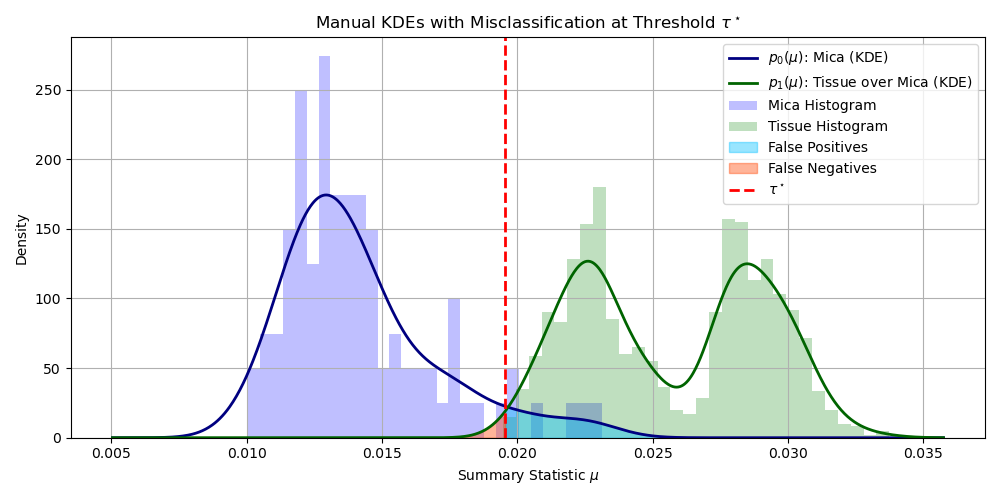

Fixed Threshold (tau*): 0.01955
Accuracy: 99.26%
False Positive Rate (FPR): 7.61%
False Negative Rate (FNR): 0.24%


In [2]:
### KDE
import numpy as np
import matplotlib.pyplot as plt

# Load data
mu_0_samples = np.mean(np.loadtxt("I_mica_data.txt"), axis=1)
mu_1_samples = np.mean(np.loadtxt("I_tissue_data.txt"), axis=1)


# Estimate parameters
mu_0 = np.mean(mu_0_samples)
mu_1 = np.mean(mu_1_samples)
sigma_0_sq = np.var(mu_0_samples, ddof=1)
sigma_1_sq = np.var(mu_1_samples, ddof=1)
sigma_0 = np.sqrt(sigma_0_sq)
sigma_1 = np.sqrt(sigma_1_sq)

# Define class priors to evaluate
priors = [0.10, 0.25, 0.50, 0.75, 0.90]
thresholds = []

for pi_1 in priors:
    pi_0 = 1 - pi_1
    if sigma_0_sq != sigma_1_sq:
        tau_star = (
            (sigma_1_sq * mu_0 - sigma_0_sq * mu_1) / (sigma_1_sq - sigma_0_sq)
            + (sigma_0 * sigma_1 / (sigma_1_sq - sigma_0_sq)) *
            np.sqrt(
                (mu_1 - mu_0) ** 2 +
                2 * (sigma_1_sq - sigma_0_sq) *
                np.log((pi_0 * sigma_1) / (pi_1 * sigma_0))
            )
        )
    else:
        tau_star = 0.5 * (mu_0 + mu_1)
    thresholds.append((pi_1, pi_0, tau_star))

# Print results in a table
print(f"{'pi_1':>6} {'pi_0':>6} {'tau_star':>12}")
print("-" * 28)
for pi_1, pi_0, tau in thresholds:
    print(f"{pi_1:6.2f} {pi_0:6.2f} {tau:12.5f}")

tau_star = thresholds[2][2]

# Define Gaussian kernel
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

# Scott's Rule bandwidth
def scott_bandwidth(data):
    n = len(data)
    std_dev = np.std(data, ddof=1)
    return std_dev * np.power(n, -1 / 5)

# Manual KDE
def kde_estimate(x, samples, h):
    n = len(samples)
    u = (x[:, None] - samples[None, :]) / h
    return np.mean(gaussian_kernel(u), axis=1) / h

# Evaluation grid
x = np.linspace(min(mu_0_samples.min(), mu_1_samples.min()) - 0.005,
                max(mu_0_samples.max(), mu_1_samples.max()) + 0.002, 1000)

# Compute KDEs
h0 = scott_bandwidth(mu_0_samples)
h1 = scott_bandwidth(mu_1_samples)
pdf_0 = kde_estimate(x, mu_0_samples, h0)
pdf_1 = kde_estimate(x, mu_1_samples, h1)

# Misclassification masks
fp_mask = x >= tau_star
fn_mask = x <= tau_star

# Plot KDEs and histograms
plt.figure(figsize=(10, 5))
plt.plot(x, pdf_0, color='navy', linewidth=2, label=r'$p_0(\mu)$: Mica (KDE)')
plt.plot(x, pdf_1, color='darkgreen', linewidth=2, label=r'$p_1(\mu)$: Tissue over Mica (KDE)')
plt.hist(mu_0_samples, bins=30, density=True, alpha=0.25, color='blue', label='Mica Histogram')
plt.hist(mu_1_samples, bins=30, density=True, alpha=0.25, color='green', label='Tissue Histogram')
plt.fill_between(x, 0, pdf_0, where=fp_mask, color='deepskyblue', alpha=0.4, label='False Positives')
plt.fill_between(x, 0, pdf_1, where=fn_mask, color='orangered', alpha=0.4, label='False Negatives')
plt.axvline(tau_star, color='red', linestyle='--', linewidth=2, label=r'$\tau^\star$')
plt.xlabel(r'Summary Statistic $\mu$')
plt.ylabel('Density')
plt.title(r'Manual KDEs with Misclassification at Threshold $\tau^\star$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification based on tau*
y_true = np.concatenate([np.zeros_like(mu_0_samples), np.ones_like(mu_1_samples)])
y_pred = np.concatenate([mu_0_samples >= tau_star, mu_1_samples >= tau_star]).astype(int)

# Confusion matrix
TP = np.sum((y_pred == 1) & (y_true == 1))
TN = np.sum((y_pred == 0) & (y_true == 0))
FP = np.sum((y_pred == 1) & (y_true == 0))
FN = np.sum((y_pred == 0) & (y_true == 1))

# Accuracy metrics
accuracy = (TP + TN) / len(y_true)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# Print results
print(f"Fixed Threshold (tau*): {tau_star:.5f}")
print(f"Accuracy: {accuracy:.2%}")
print(f"False Positive Rate (FPR): {FPR:.2%}")
print(f"False Negative Rate (FNR): {FNR:.2%}")

$\text{Tissue}$ samples :1259, I_mica samples :92, Features : 211
Emperical prior π_0 = 0.068098, π_1 = 0.931902 with prior_ratio: 0.073074
Bayes-optimal threshold τ*: 0.018728 on prior_ratio: 0.333333
μ = 0.00130 classified as class 0


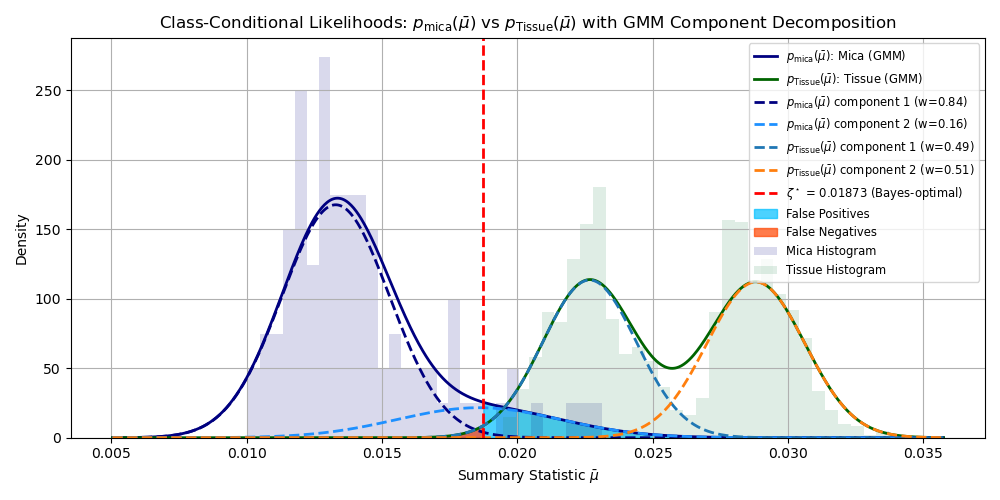

In [3]:
### paper implementation - Bayes optimal threshold
%matplotlib widget
import numpy as np
from scipy.optimize import brentq
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Load data ---
np.random.seed(0)
I_mica = np.loadtxt("I_mica_data.txt")       # shape (M, d)

qgrid = np.loadtxt('../data/q_data.txt')
lidx =  np.argmin(np.abs(qgrid-0.4))  # 0.4   qgrid_to_indices(qgrid2, 0.4) 
uidx =  np.argmin(np.abs(qgrid-1.45))

feature_values = np.round(qgrid, 4)  # Handle numerical precision
mask = (feature_values >= 0.4) & (feature_values <= 1.45)
selected_indices = np.where(mask)[0]


X_tissue = np.loadtxt('../data/I_tissue_div_data.txt')[:,selected_indices]  
X_cross  = np.loadtxt('../data/I_cross_data.txt')[:,selected_indices]  
X_all    = np.concatenate([X_tissue, X_cross], axis=0)


I_tissue =  X_all  # shape (N, d)  np.loadtxt("I_tissue_data.txt") X_all   # X_all         X_cross   X_tissue 
annot    =  r'tissue'     # r'tissue'  r'\beta'  r'\neg\beta'
assert I_mica.shape[1] == I_tissue.shape[1], 'I_tissue and I_mica shape mismatch'
annot_display = annot if annot.startswith("\\") else fr"\text{{{annot.capitalize()}}}"
print(fr"${annot_display}$ samples :{len(I_tissue)}, I_mica samples :{len(I_mica)}, Features : {I_tissue.shape[1]}")

mu_0 = I_mica.mean(axis=1)
mu_1 = I_tissue.mean(axis=1)
M, N = len(mu_0), len(mu_1)

# --- Compute class priors ---
pi_0 = M / (M + N)
pi_1 = N / (M + N)
pi_1_emp = pi_1
prior_ratio = 0.25/0.75  # 0.75  pi_0 / pi_1
max_k = 10

# --- Fit GMMs with BIC model selection ---
def fit_gmm_bic(data, max_k=max_k):
    bics = []
    best_gmm = None
    lowest_bic = np.inf
    for k in range(1, max_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(data.reshape(-1, 1))
        bic = gmm.bic(data.reshape(-1, 1))
        bics.append(bic)
        if bic < lowest_bic:
            lowest_bic = gmm.bic(data.reshape(-1, 1))
            best_gmm = gmm
    return best_gmm, bics

gmm_mica, bics_mica     = fit_gmm_bic(mu_0)
gmm_tissue, bics_tissue = fit_gmm_bic(mu_1)

# --- Extract GMM parameters ---
weights_mica = gmm_mica.weights_
means_mica = gmm_mica.means_.flatten()
stds_mica = np.sqrt(gmm_mica.covariances_.flatten())

weights_tissue = gmm_tissue.weights_
means_tissue = gmm_tissue.means_.flatten()
stds_tissue = np.sqrt(gmm_tissue.covariances_.flatten())

# --- Define GMM likelihood function ---
def p_gmm(mu, gmm):
    return np.exp(gmm.score_samples(mu.reshape(-1, 1)))

# --- Evaluation domain ---
x = np.linspace(min(mu_0.min(), mu_1.min()) - 0.005,
                max(mu_0.max(), mu_1.max()) + 0.002, 1000)

# --- Define posterior-adjusted likelihood ratio deviation ---
def likelihood_ratio_with_prior(mu):
    p0 = p_gmm(np.array([mu]), gmm_mica)[0]
    p1 = p_gmm(np.array([mu]), gmm_tissue)[0]
    return (p1 / p0) - prior_ratio

# --- Find Bayes-optimal threshold τ* where posterior odds = 1 ---
tau_star = brentq(likelihood_ratio_with_prior, x.min(), x.max())

# --- Display results ---
print(f"Emperical prior π_0 = {pi_0:.6f}, π_1 = {pi_1:.6f} with prior_ratio: {pi_0 / pi_1:.6f}")
print(f"Bayes-optimal threshold τ*: {tau_star:.6f} on prior_ratio: {prior_ratio:.6f}")

# --- Inference on new sample ---
def classify(mu_test):
    return 1 if mu_test >= tau_star else 0

# --- Example test point ---
mu_test = 0.0013
y_hat = classify(mu_test)
print(f"μ = {mu_test:.5f} classified as class {y_hat}")

pdf_0 = p_gmm(x, gmm_mica)
pdf_1 = p_gmm(x, gmm_tissue)

# --- Plot PDFs and threshold ---

# Masks for misclassification shading
fp_mask = x >= tau_star
fn_mask = x <= tau_star

# Precompute display strings for LaTeX and plain text
if annot.startswith("\\"):  # LaTeX case like \beta
    annot_display = annot  # for inside math mode
    annot_text = f"${annot}$"  # for outside math mode text parts
    annot_text_hist = f"${annot}$ Histogram"
else:  # plain text case
    annot_display = fr"\text{{{annot.capitalize()}}}"
    annot_text = annot.capitalize()
    annot_text_hist = f"{annot.capitalize()} Histogram"

# Plot
plt.close('all')
plt.figure(figsize=(10, 5)) #  dpi=400
plt.plot(x, pdf_0, color='navy', linewidth=2, label=r'$p_{\text{mica}}(\bar{\mu})$: Mica (GMM)')
label = fr"$p_{{{annot_display}}}(\bar{{\mu}})$: {annot_text} (GMM)"

plt.plot(x, pdf_1, color='darkgreen', linewidth=2, label=label)

# Plot individual components for mica
colors_mica = ['navy', 'dodgerblue']
for i, (w, m, s) in enumerate(zip(weights_mica, means_mica, stds_mica)):
    label = r'$p_{\text{mica}}(\bar{\mu})$' + f' component {i+1} (w={w:.2f})'
    plt.plot(x, w * norm.pdf(x, m, s), '--', linewidth=2, color=colors_mica[i], label=label)

# Plot individual components for tissue
# colors_tissue = ['darkgreen', 'goldenrod']
for i, (w, m, s) in enumerate(zip(weights_tissue, means_tissue, stds_tissue)):
    label_component = fr"$p_{{{annot_display}}}(\bar{{\mu}})$ component {i+1} (w={w:.2f})"
    plt.plot(x, w * norm.pdf(x, m, s), '--', linewidth=2, label=label_component)  #### show all components # color=colors_tissue[i]

# Decision threshold and shading
plt.axvline(tau_star, color='red', linestyle='--', linewidth=2,
            label=fr'$\zeta^\star$ = {tau_star:.5f} (Bayes-optimal)')
plt.fill_between(x, 0, pdf_0, where=fp_mask, color='deepskyblue', alpha=0.7, label='False Positives')
plt.fill_between(x, 0, pdf_1, where=fn_mask, color='orangered', alpha=0.7, label='False Negatives')

# Histograms
plt.hist(mu_0, bins=30, density=True, alpha=0.15, color='navy', label='Mica Histogram')
plt.hist(mu_1, bins=30, density=True, alpha=0.15, color='seagreen', label=annot_text_hist)

# Final formatting
plt.xlabel(r'Summary Statistic $\bar{\mu}$')
plt.ylabel('Density')
plt.title(
    fr"Class-Conditional Likelihoods: $p_{{\text{{mica}}}}(\bar{{\mu}})$ "
    fr"vs $p_{{{annot_display}}}(\bar{{\mu}})$ with GMM Component Decomposition"
)
plt.legend(fontsize='small')  # or use a specific size like 9
plt.grid(True)
plt.tight_layout()
plt.show()

  pi_1   pi_0     tau_star   Accuracy        FPR        FNR
------------------------------------------------------------
  0.10   0.90      0.02196     86.31%      3.26%     14.46%
  0.25   0.75      0.02054     96.97%      4.35%      2.94%
  0.50   0.50      0.01952     99.26%      7.61%      0.24%
  0.75   0.25      0.01873     99.48%      7.61%      0.00%
  0.90   0.10      0.01808     99.41%      8.70%      0.00%
  0.93   0.07      0.01786     99.26%     10.87%      0.00%




Best Model 
  pi_1   pi_0     tau_star   Accuracy        FPR        FNR
------------------------------------------------------------
  0.75   0.25      0.01873     99.48%      7.61%      0.00%


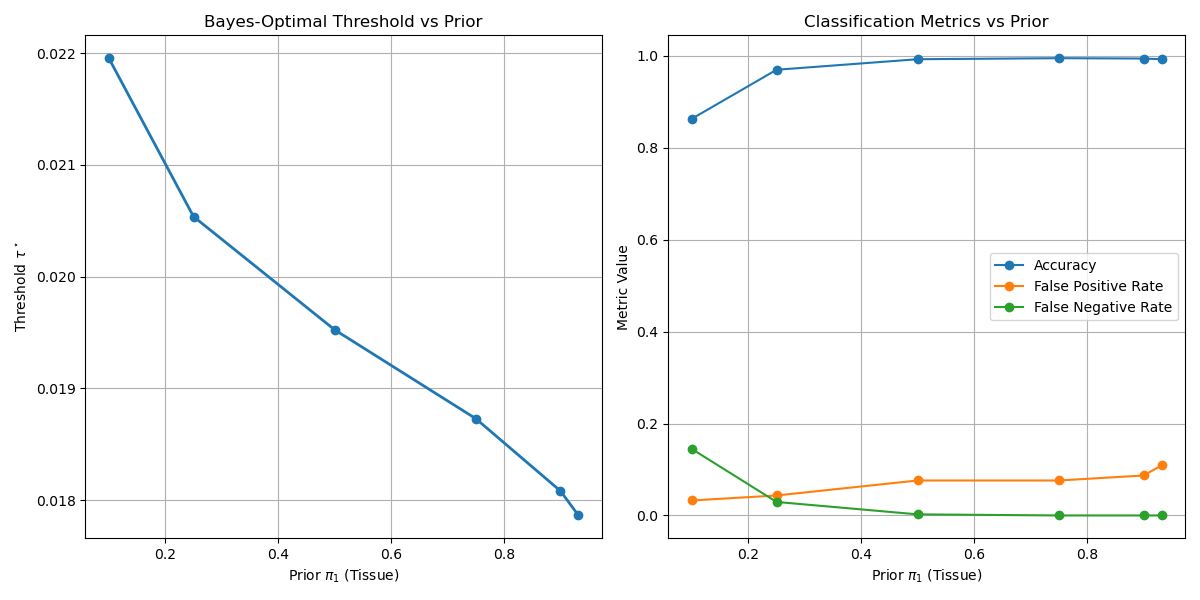

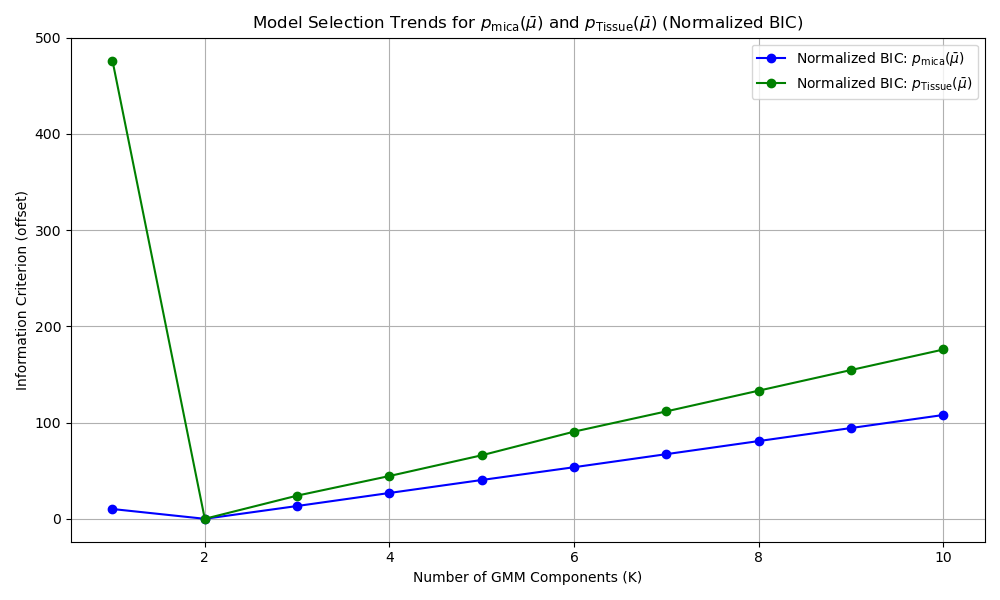

In [4]:
# --- Evaluate priors and thresholds --- - paper implementation
priors = [ 0.10, 0.25, 0.50, 0.75, 0.90, pi_1_emp]
results = []

for pi_1 in priors:
    pi_0 = 1 - pi_1
    prior_ratio = pi_0 / pi_1  # 0.75  pi_0 / pi_1

    def likelihood_ratio_with_prior(mu):
        p0 = p_gmm(np.array([mu]), gmm_mica)[0]  # p(μ|C=0)
        p1 = p_gmm(np.array([mu]), gmm_tissue)[0]  # p(μ|C=1)
        return (p1 / p0) - prior_ratio  # LR - prior ratio  prior_ratio = pi_0 / pi_1
    
    # Find root where LR = prior ratio using Brent's method
    tau_star = brentq(likelihood_ratio_with_prior, x.min(), x.max())

    # classification and metric calculations
    y_true = np.concatenate([np.zeros_like(mu_0), np.ones_like(mu_1)])
    y_pred = np.concatenate([mu_0 >= tau_star, mu_1 >= tau_star]).astype(int)

    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))

    accuracy = (TP + TN) / len(y_true)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    results.append((pi_1, pi_0, tau_star, accuracy, FPR, FNR))

# --- Print Table ---
print(f"{'pi_1':>6} {'pi_0':>6} {'tau_star':>12} {'Accuracy':>10} {'FPR':>10} {'FNR':>10}")
print("-" * 60)
for pi_1, pi_0, tau_star, accuracy, FPR, FNR in results:
    print(f"{pi_1:6.2f} {pi_0:6.2f} {tau_star:12.5f} {accuracy:10.2%} {FPR:10.2%} {FNR:10.2%}")

# --- best model ---
print("\n\n\n")
print("Best Model ")
print(f"{'pi_1':>6} {'pi_0':>6} {'tau_star':>12} {'Accuracy':>10} {'FPR':>10} {'FNR':>10}")
print("-" * 60)

# Find and print best result with proper formatting
best_tuple = results[np.argmax([t[3] for t in results])]
print(f"{best_tuple[0]:6.2f} "
      f"{best_tuple[1]:6.2f} "
      f"{best_tuple[2]:12.5f} "
      f"{best_tuple[3]:10.2%} "
      f"{best_tuple[4]:10.2%} "
      f"{best_tuple[5]:10.2%}")

# --- Plot Threshold vs Prior ---
pi_vals, tau_vals, acc_vals, fpr_vals, fnr_vals = zip(
    *[(pi_1, tau_star, accuracy, FPR, FNR) for pi_1, _, tau_star, accuracy, FPR, FNR in results]
)
plt.close('all')

plt.figure(figsize=(12, 6), ) # dpi=400

plt.subplot(1, 2, 1)
plt.plot(pi_vals, tau_vals, marker='o', linewidth=2)
plt.xlabel(fr'Prior $\pi_1$ ({annot_text})')
plt.ylabel(r'Threshold $\tau^\star$')
plt.title('Bayes-Optimal Threshold vs Prior')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(pi_vals, acc_vals, label='Accuracy', marker='o')
plt.plot(pi_vals, fpr_vals, label='False Positive Rate', marker='o')
plt.plot(pi_vals, fnr_vals, label='False Negative Rate', marker='o')
plt.xlabel(fr'Prior $\pi_1$ ({annot_text})')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs Prior')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### bic plot
ks = range(1, max_k+1)
norm_bics_mica   = bics_mica - np.min(bics_mica)
norm_bics_tissue = bics_tissue - np.min(bics_tissue)

# Plot
plt.figure(figsize=(10, 6))  # dpi=400
plt.plot(ks, norm_bics_mica, 'b-o', label=r'Normalized BIC: $p_{\text{mica}}(\bar{\mu})$')
plt.plot(ks, norm_bics_tissue, 'g-o', label=fr"Normalized BIC: $p_{{{annot_display}}}(\bar{{\mu}})$")
plt.xlabel("Number of GMM Components (K)")
plt.ylabel("Information Criterion (offset)")
plt.title(
    fr"Model Selection Trends for $p_{{\text{{mica}}}}(\bar{{\mu}})$ "
    fr"and $p_{{{annot_display}}}(\bar{{\mu}})$ (Normalized BIC)"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Responsibilities (soft association) at x = 2.5:
Component 1: 1.3207%
Component 2: 98.5572%
Component 3: 0.1220%


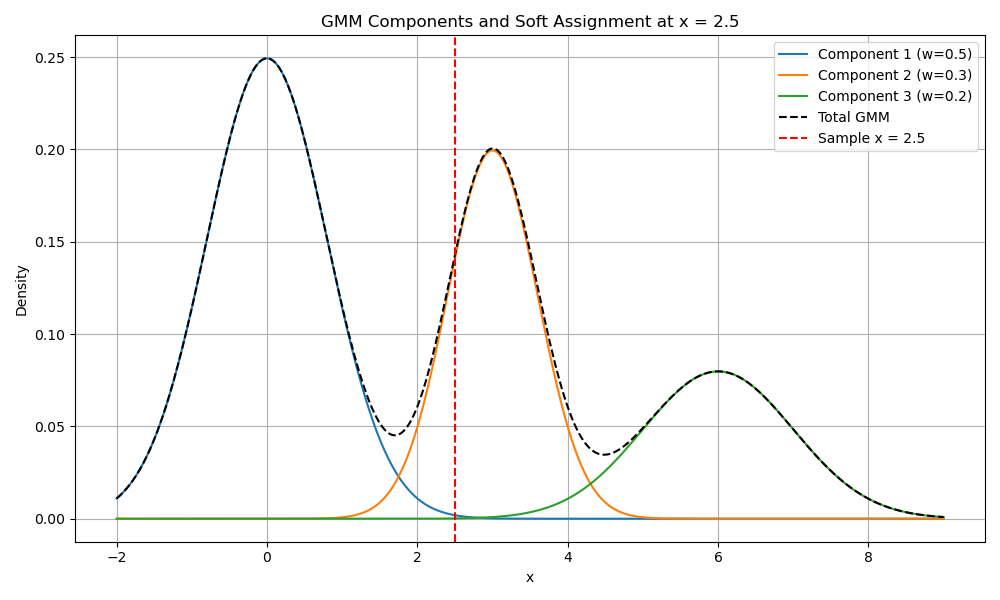

In [5]:
## GMM tutorials 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# GMM parameters
weights = np.array([0.5, 0.3, 0.2])
means = np.array([0, 3, 6])
std_devs = np.array([0.8, 0.6, 1.0])

# Evaluation range
x = np.linspace(-2, 9, 1000)

# Compute component densities
components = [w * norm.pdf(x, loc=m, scale=s) for w, m, s in zip(weights, means, std_devs)]

# Full GMM density
gmm_pdf = np.sum(components, axis=0)



# Choose a sample point
x0 = 2.5

# Compute responsibilities
numerators = [w * norm.pdf(x0, loc=m, scale=s) for w, m, s in zip(weights, means, std_devs)]
denominator = np.sum(numerators)
responsibilities = np.array(numerators) / denominator

# Output responsibilities
print("Responsibilities (soft association) at x = 2.5:")
for i, r in enumerate(responsibilities):
    print(f"Component {i+1}: {r:.4%}")

# Plotting
plt.figure(figsize=(10, 6))
for i, comp in enumerate(components):
    plt.plot(x, comp, label=f'Component {i+1} (w={weights[i]})')
plt.plot(x, gmm_pdf, 'k--', label='Total GMM')
plt.axvline(x0, color='red', linestyle='--', label=f'Sample x = {x0}')
plt.title('GMM Components and Soft Assignment at x = 2.5')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

COMPLETE 1D + 3D VISUALIZER


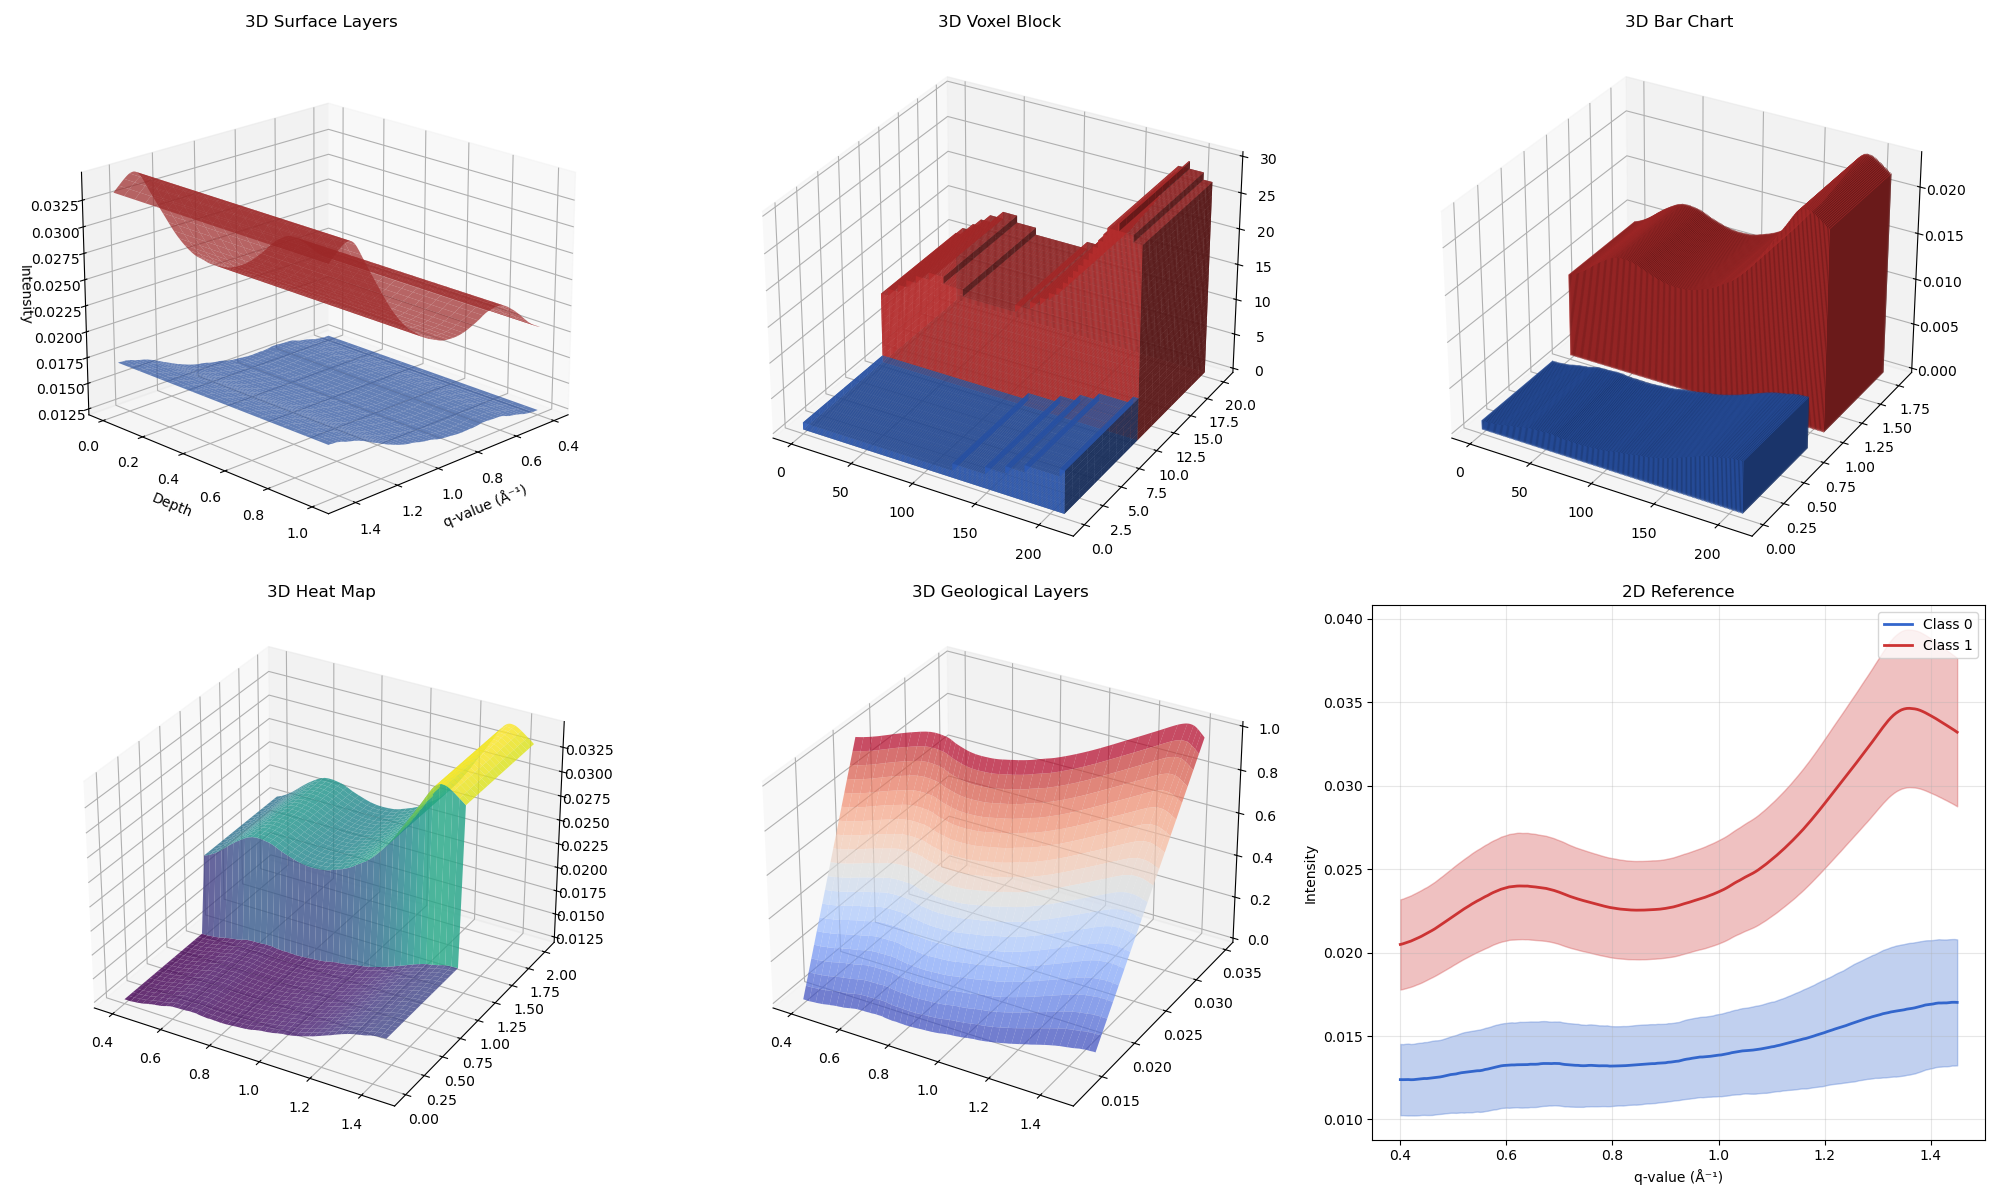

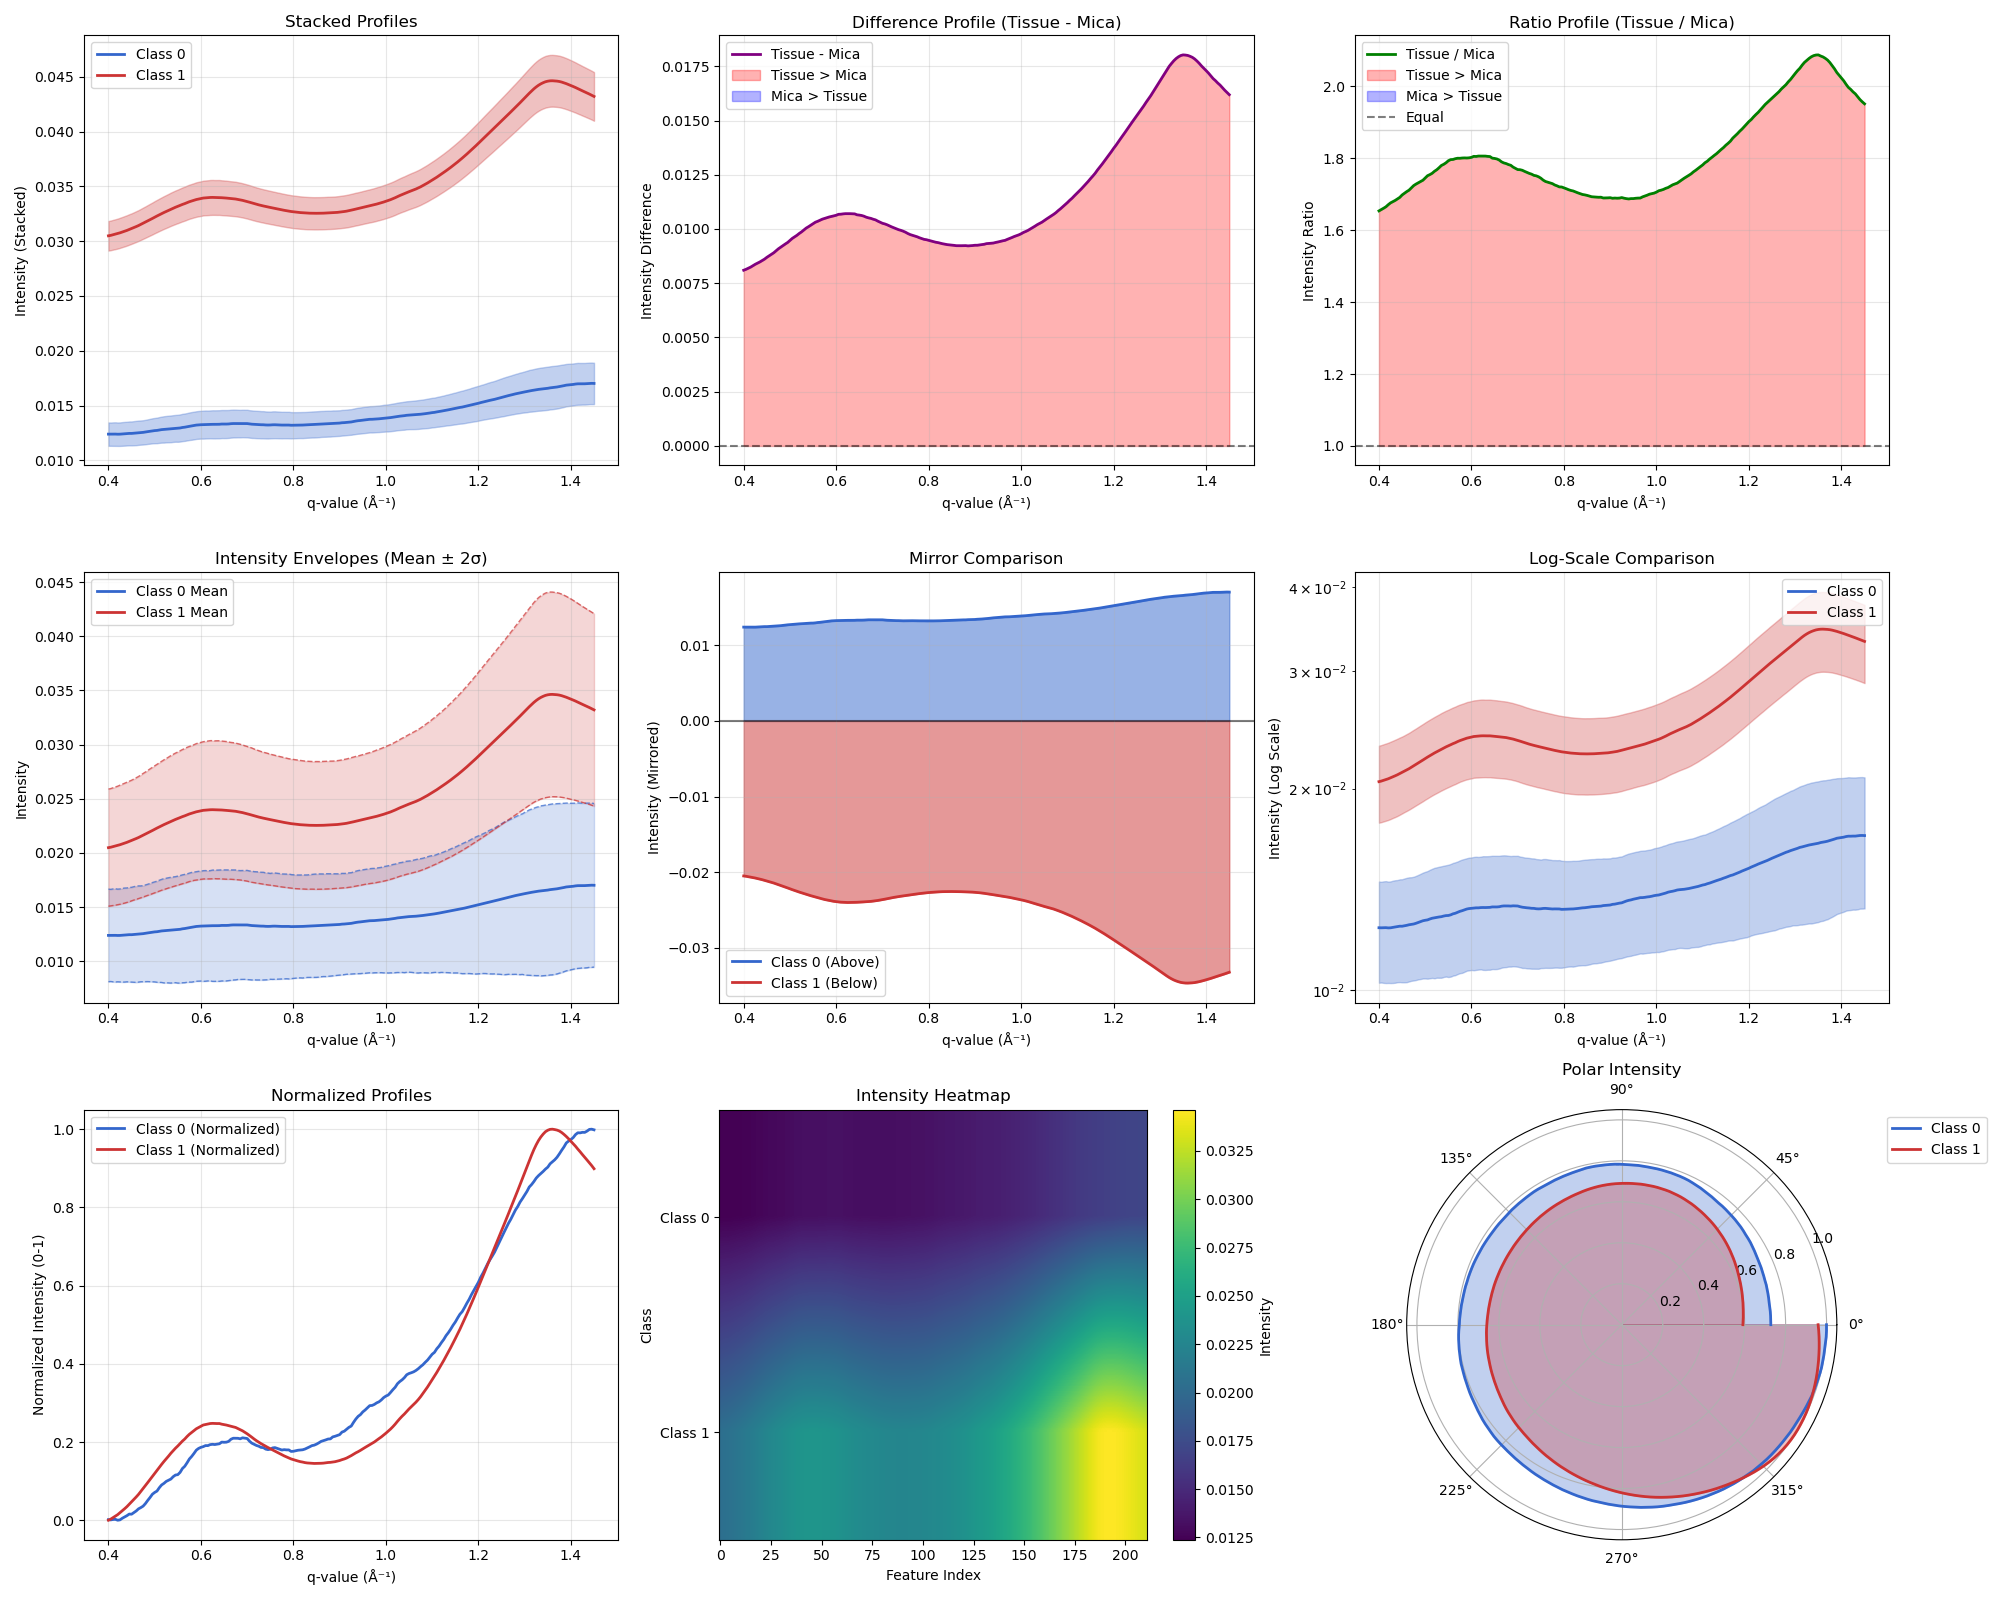


✓ Analysis complete! Check all_plots/ for saved plots.
Generated:
  - 3D plots: 6 methods
  - 1D plots: 9 methods
  - Total: 15 different visualizations


'\nThis script generates 15 different visualizations:\n\n3D PLOTS (6 methods):\n1. Surface Layers - 3D surfaces at original intensity\n2. Voxel Block - Minecraft-style blocks  \n3. Bar Chart - 3D city skyline\n4. Heat Map Block - Continuous color surface\n5. Geological Layers - Smooth class transitions\n6. 2D Reference - Standard comparison plot\n\n1D PLOTS (9 methods):\n1. Stacked Profiles - Vertically offset for clarity\n2. Difference Profile - Shows Tissue - Mica differences\n3. Ratio Profile - Shows Tissue / Mica ratios\n4. Envelope Comparison - Mean ± 2σ error bands\n5. Mirror Comparison - One class above, one below x-axis\n6. Log Comparison - Logarithmic scale\n7. Normalized Comparison - Each class scaled 0-1\n8. Heatmap - Classes as rows, features as columns\n9. Polar Plot - Circular representation\n\nAll plots use your q-values as x-axis and show mica vs tissue differences.\nSaves two files: *_3d_methods.png and *_1d_methods.png\n'

In [6]:
#!/usr/bin/env python3
"""
Complete Standalone 1D and 3D Feature Intensity Visualizer
=========================================================

Generates both 3D and additional 1D visualizations for feature intensity data.
Works with numpy arrays loaded via np.loadtxt().

Usage:
1. Load your data with np.loadtxt()
2. Create data dictionary: {0: I_mica, 1: I_tissue}
3. Run main(data, q_values)
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from typing import Dict, List, Optional, Union
import logging
from scipy import stats

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Output settings
OUTPUT_DIR = "all_plots"
PLOT_NAME = "mica_tissue_analysis"

class CompleteVisualizer:
    """Complete visualizer with both 3D and 1D methods."""
    
    def __init__(self, plot_dir: Union[str, Path]):
        """Initialize with plot directory."""
        self.plot_dir = Path(plot_dir)
        self.plot_dir.mkdir(parents=True, exist_ok=True)
        
    def prepare_data(self, data: Dict[int, Union[np.ndarray, List[np.ndarray]]], 
                     feature_metadata: Optional[np.ndarray] = None) -> Dict:
        """Prepare data arrays for visualization."""
        logger.info("Preparing data arrays...")
        
        X_by_class = {}
        feature_counts = {}
        
        for class_label, arrays in data.items():
            if isinstance(arrays, np.ndarray):
                arrays = [arrays]
            
            # Combine arrays for this class
            if len(arrays) == 1:
                combined_data = arrays[0]
            else:
                min_features_class = min(arr.shape[1] for arr in arrays)
                aligned_arrays = [arr[:, :min_features_class] for arr in arrays]
                combined_data = np.vstack(aligned_arrays)
            
            X_by_class[class_label] = combined_data
            feature_counts[class_label] = combined_data.shape[1]
            logger.info(f"Class {class_label}: {combined_data.shape[0]} samples, {combined_data.shape[1]} features")
        
        # Align to minimum features across all classes
        n_features_list = list(feature_counts.values())
        if len(set(n_features_list)) > 1:
            min_features = min(n_features_list)
            logger.info(f"Aligning all classes to {min_features} features")
            
            for class_label in X_by_class.keys():
                X_by_class[class_label] = X_by_class[class_label][:, :min_features]
            
            n_features = min_features
        else:
            n_features = n_features_list[0]
        
        # Validate feature metadata
        if feature_metadata is not None:
            if len(feature_metadata) != n_features:
                feature_metadata = feature_metadata[:n_features]
        
        # Store raw data for advanced plots
        self.X_by_class_raw = X_by_class  # Store for waterfall plot
        
        return {
            'X_by_class': X_by_class,
            'feature_metadata': feature_metadata,
            'selected_indices': np.arange(n_features),  # All features
            'n_features': n_features,
            'class_labels': list(X_by_class.keys())
        }
    
    def generate_all_plots(self, X_by_class, selected_indices, feature_metadata=None, plot_name="analysis"):
        """Generate both 3D and 1D visualizations."""
        class_labels = sorted(X_by_class.keys())
        n_classes = len(class_labels)
        
        # Compute statistics
        class_stats = {}
        for label in class_labels:
            X_class = X_by_class[label]
            class_stats[label] = {
                'mean': X_class.mean(axis=0),
                'std': X_class.std(axis=0),
                'n_samples': X_class.shape[0]
            }
        
        # Prepare feature axis
        n_features = class_stats[class_labels[0]]['mean'].shape[0]
        if feature_metadata is not None:
            feature_axis = feature_metadata
            x_label = 'q-value (Å⁻¹)'
        else:
            feature_axis = np.arange(n_features)
            x_label = 'Feature Index'
        
        colors = self._generate_class_colors(n_classes)
        
        logger.info(f"Generating visualizations for {n_classes} classes, {n_features} features")
        
        # =============================================================================
        # 3D PLOTS (Original)
        # =============================================================================
        fig1 = plt.figure(figsize=(20, 12))
        
        self._plot_surface_layers(fig1, 2, 3, 1, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_voxel_block(fig1, 2, 3, 2, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_bar_chart(fig1, 2, 3, 3, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_heat_map_block(fig1, 2, 3, 4, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_geological_layers(fig1, 2, 3, 5, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_2d_reference(fig1, 2, 3, 6, feature_axis, class_stats, x_label, colors, class_labels)
        
        plt.tight_layout()
        save_path1 = self.plot_dir / f'{plot_name}_3d_methods.png'
        plt.savefig(save_path1, dpi=300, bbox_inches='tight')
        plt.show()
        
        # =============================================================================
        # 1D PLOTS (New)
        # =============================================================================
        fig2 = plt.figure(figsize=(20, 16))
        
        self._plot_stacked_profiles(fig2, 3, 3, 1, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_difference_profile(fig2, 3, 3, 2, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_ratio_profile(fig2, 3, 3, 3, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_envelope_comparison(fig2, 3, 3, 4, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_mirror_comparison(fig2, 3, 3, 5, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_log_comparison(fig2, 3, 3, 6, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_normalized_comparison(fig2, 3, 3, 7, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_heatmap_comparison(fig2, 3, 3, 8, feature_axis, class_stats, x_label, colors, class_labels)
        self._plot_polar_intensity(fig2, 3, 3, 9, feature_axis, class_stats, x_label, colors, class_labels)
        
        plt.tight_layout()
        save_path2 = self.plot_dir / f'{plot_name}_1d_methods.png'
        plt.savefig(save_path2, dpi=300, bbox_inches='tight')
        plt.show()
        
        logger.info(f"All plots saved to {self.plot_dir}")
    
    def _generate_class_colors(self, n_classes: int) -> List[tuple]:
        """Generate distinct colors for each class."""
        if n_classes == 2:
            return [(0.2, 0.4, 0.8), (0.8, 0.2, 0.2)]  # Blue, Red
        else:
            from matplotlib import cm
            cmap = cm.get_cmap('tab10' if n_classes <= 10 else 'tab20')
            return [cmap(i / max(n_classes-1, 1))[:3] for i in range(n_classes)]
    
    # =============================================================================
    # 3D PLOT METHODS (Simplified)
    # =============================================================================
    
    def _plot_surface_layers(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """3D surface layers - original intensity levels."""
        ax = fig.add_subplot(rows, cols, pos, projection='3d')
        
        Y = np.linspace(0, 1, 20)
        Q, Y_mesh = np.meshgrid(feature_axis, Y)
        
        for i, label in enumerate(class_labels):
            class_mean = class_stats[label]['mean']
            Z_class = np.outer(np.ones(len(Y)), class_mean)
            ax.plot_surface(Q, Y_mesh, Z_class, alpha=0.7, color=colors[i])
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Depth')
        ax.set_zlabel('Intensity')
        ax.set_title('3D Surface Layers')
        ax.view_init(elev=20, azim=45)
        return ax
    
    def _plot_voxel_block(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """3D voxel block."""
        ax = fig.add_subplot(rows, cols, pos, projection='3d')
        
        nx, ny, nz = len(feature_axis), max(20, len(class_labels) * 5), 30
        all_means = np.concatenate([class_stats[label]['mean'] for label in class_labels])
        int_min, int_max = all_means.min(), all_means.max()
        
        filled = np.zeros((nx, ny, nz), dtype=bool)
        colors_array = np.empty((nx, ny, nz, 4))
        y_per_class = ny // len(class_labels)
        
        for class_idx, label in enumerate(class_labels):
            class_mean = class_stats[label]['mean']
            y_start, y_end = class_idx * y_per_class, min((class_idx + 1) * y_per_class, ny)
            
            if int_max > int_min:
                heights = ((class_mean - int_min) / (int_max - int_min) * (nz-1)).astype(int)
            else:
                heights = np.ones(nx, dtype=int) * (nz//2)
            
            for i in range(nx):
                h = max(1, min(heights[i], nz-1))
                filled[i, y_start:y_end, :h] = True
                colors_array[i, y_start:y_end, :h] = list(colors[class_idx]) + [0.8]
        
        ax.voxels(filled, facecolors=colors_array, alpha=0.8)
        ax.set_title('3D Voxel Block')
        return ax
    
    def _plot_bar_chart(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """3D bar chart."""
        ax = fig.add_subplot(rows, cols, pos, projection='3d')
        
        xpos = np.arange(len(feature_axis))
        base_height = min([class_stats[label]['mean'].min() for label in class_labels])
        dx = 0.8 / len(class_labels)
        
        for class_idx, label in enumerate(class_labels):
            class_mean = class_stats[label]['mean']
            ypos = np.full(len(feature_axis), class_idx)
            dz = class_mean - base_height + 0.001
            x_offset = xpos + class_idx * dx
            
            ax.bar3d(x_offset, ypos, np.zeros(len(feature_axis)), dx, 0.8, dz, 
                    color=colors[class_idx], alpha=0.7)
        
        ax.set_title('3D Bar Chart')
        return ax
    
    def _plot_heat_map_block(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """3D heat map block."""
        ax = fig.add_subplot(rows, cols, pos, projection='3d')
        
        Y_heat = np.linspace(0, len(class_labels), 40)
        Q_heat, Y_heat_mesh = np.meshgrid(feature_axis, Y_heat)
        Z_heat = np.zeros_like(Q_heat)
        
        for i, y in enumerate(Y_heat):
            class_idx = min(int(y), len(class_labels) - 1)
            class_label = class_labels[class_idx]
            Z_heat[i, :] = class_stats[class_label]['mean']
        
        ax.plot_surface(Q_heat, Y_heat_mesh, Z_heat, cmap='viridis', alpha=0.8)
        ax.set_title('3D Heat Map')
        return ax
    
    def _plot_geological_layers(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """3D geological layers - simplified."""
        ax = fig.add_subplot(rows, cols, pos, projection='3d')
        
        Z_layers = np.linspace(0, 1, 20)
        Q_layer, Z_layer_mesh = np.meshgrid(feature_axis, Z_layers)
        intensity_field = np.zeros_like(Q_layer)
        
        if len(class_labels) == 1:
            for i in range(len(Z_layers)):
                intensity_field[i, :] = class_stats[class_labels[0]]['mean']
        else:
            first_mean = class_stats[class_labels[0]]['mean']
            last_mean = class_stats[class_labels[-1]]['mean']
            for i, z in enumerate(Z_layers):
                intensity_field[i, :] = (1-z) * first_mean + z * last_mean
        
        ax.plot_surface(Q_layer, intensity_field, Z_layer_mesh, cmap='coolwarm', alpha=0.7)
        ax.set_title('3D Geological Layers')
        return ax
    
    def _plot_2d_reference(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """2D reference plot."""
        ax = fig.add_subplot(rows, cols, pos)
        
        for class_idx, label in enumerate(class_labels):
            class_mean = class_stats[label]['mean']
            class_std = class_stats[label]['std']
            
            ax.plot(feature_axis, class_mean, '-', color=colors[class_idx], 
                   linewidth=2, label=f'Class {label}')
            ax.fill_between(feature_axis, class_mean - class_std, class_mean + class_std, 
                           color=colors[class_idx], alpha=0.3)
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity')
        ax.set_title('2D Reference')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    # =============================================================================
    # 1D PLOT METHODS
    # =============================================================================
    
    def _plot_stacked_profiles(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Stacked intensity profiles with offset."""
        ax = fig.add_subplot(rows, cols, pos)
        
        offset_step = 0.01
        for i, label in enumerate(class_labels):
            class_mean = class_stats[label]['mean']
            class_std = class_stats[label]['std']
            y_offset = i * offset_step
            
            ax.plot(feature_axis, class_mean + y_offset, '-', 
                   color=colors[i], linewidth=2, label=f'Class {label}')
            ax.fill_between(feature_axis, 
                           class_mean + y_offset - class_std/2, 
                           class_mean + y_offset + class_std/2, 
                           color=colors[i], alpha=0.3)
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity (Stacked)')
        ax.set_title('Stacked Profiles')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_difference_profile(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Difference profiles (Class1 - Class0)."""
        ax = fig.add_subplot(rows, cols, pos)
        
        if len(class_labels) >= 2:
            mean1 = class_stats[class_labels[1]]['mean']
            mean0 = class_stats[class_labels[0]]['mean']
            diff = mean1 - mean0
            
            ax.plot(feature_axis, diff, '-', linewidth=2, color='purple', label='Tissue - Mica')
            ax.fill_between(feature_axis, 0, diff, alpha=0.3, 
                           where=(diff > 0), color='red', interpolate=True, 
                           label='Tissue > Mica')
            ax.fill_between(feature_axis, 0, diff, alpha=0.3, 
                           where=(diff < 0), color='blue', interpolate=True, 
                           label='Mica > Tissue')
        
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity Difference')
        ax.set_title('Difference Profile (Tissue - Mica)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_ratio_profile(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Ratio profiles (Class1/Class0)."""
        ax = fig.add_subplot(rows, cols, pos)
        
        if len(class_labels) >= 2:
            mean1 = class_stats[class_labels[1]]['mean']
            mean0 = class_stats[class_labels[0]]['mean']
            
            ratio = np.divide(mean1, mean0, out=np.ones_like(mean1), where=mean0!=0)
            
            ax.plot(feature_axis, ratio, '-', linewidth=2, color='green', 
                   label='Tissue / Mica')
            ax.fill_between(feature_axis, 1, ratio, alpha=0.3, 
                           where=(ratio > 1), color='red', interpolate=True,
                           label='Tissue > Mica')
            ax.fill_between(feature_axis, 1, ratio, alpha=0.3, 
                           where=(ratio < 1), color='blue', interpolate=True,
                           label='Mica > Tissue')
        
        ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal')
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity Ratio')
        ax.set_title('Ratio Profile (Tissue / Mica)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_envelope_comparison(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Envelope comparison (min/max ranges)."""
        ax = fig.add_subplot(rows, cols, pos)
        
        for i, label in enumerate(class_labels):
            mean = class_stats[label]['mean']
            std = class_stats[label]['std']
            
            ax.plot(feature_axis, mean, '-', color=colors[i], linewidth=2, 
                   label=f'Class {label} Mean')
            
            upper = mean + 2*std
            lower = mean - 2*std
            ax.plot(feature_axis, upper, '--', color=colors[i], alpha=0.7, linewidth=1)
            ax.plot(feature_axis, lower, '--', color=colors[i], alpha=0.7, linewidth=1)
            ax.fill_between(feature_axis, lower, upper, color=colors[i], alpha=0.2)
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity')
        ax.set_title('Intensity Envelopes (Mean ± 2σ)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_mirror_comparison(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Mirror plot (classes above/below x-axis)."""
        ax = fig.add_subplot(rows, cols, pos)
        
        if len(class_labels) >= 2:
            mean0 = class_stats[class_labels[0]]['mean']
            mean1 = class_stats[class_labels[1]]['mean']
            
            ax.plot(feature_axis, mean0, '-', color=colors[0], linewidth=2, 
                   label=f'Class {class_labels[0]} (Above)')
            ax.fill_between(feature_axis, 0, mean0, color=colors[0], alpha=0.5)
            
            ax.plot(feature_axis, -mean1, '-', color=colors[1], linewidth=2, 
                   label=f'Class {class_labels[1]} (Below)')
            ax.fill_between(feature_axis, 0, -mean1, color=colors[1], alpha=0.5)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity (Mirrored)')
        ax.set_title('Mirror Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_log_comparison(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Log-scale comparison."""
        ax = fig.add_subplot(rows, cols, pos)
        
        for i, label in enumerate(class_labels):
            mean = class_stats[label]['mean']
            std = class_stats[label]['std']
            
            mean_positive = np.maximum(mean, 1e-10)
            ax.plot(feature_axis, mean_positive, '-', color=colors[i], linewidth=2, 
                   label=f'Class {label}')
            
            upper = np.maximum(mean + std, 1e-10)
            lower = np.maximum(mean - std, 1e-10)
            ax.fill_between(feature_axis, lower, upper, color=colors[i], alpha=0.3)
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Intensity (Log Scale)')
        ax.set_yscale('log')
        ax.set_title('Log-Scale Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_normalized_comparison(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Normalized profiles (0-1 scale)."""
        ax = fig.add_subplot(rows, cols, pos)
        
        for i, label in enumerate(class_labels):
            mean = class_stats[label]['mean']
            mean_norm = (mean - mean.min()) / (mean.max() - mean.min())
            
            ax.plot(feature_axis, mean_norm, '-', color=colors[i], linewidth=2, 
                   label=f'Class {label} (Normalized)')
        
        ax.set_xlabel(x_label)
        ax.set_ylabel('Normalized Intensity (0-1)')
        ax.set_title('Normalized Profiles')
        ax.legend()
        ax.grid(True, alpha=0.3)
        return ax
    
    def _plot_heatmap_comparison(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Heatmap with classes as rows."""
        ax = fig.add_subplot(rows, cols, pos)
        
        intensity_matrix = np.array([class_stats[label]['mean'] for label in class_labels])
        im = ax.imshow(intensity_matrix, aspect='auto', cmap='viridis', interpolation='bilinear')
        
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Class')
        ax.set_yticks(range(len(class_labels)))
        ax.set_yticklabels([f'Class {label}' for label in class_labels])
        ax.set_title('Intensity Heatmap')
        plt.colorbar(im, ax=ax, label='Intensity')
        return ax
    
    def _plot_polar_intensity(self, fig, rows, cols, pos, feature_axis, class_stats, x_label, colors, class_labels):
        """Polar plot (intensity as radius)."""
        ax = fig.add_subplot(rows, cols, pos, projection='polar')
        
        theta = np.linspace(0, 2*np.pi, len(feature_axis))
        
        for i, label in enumerate(class_labels):
            mean = class_stats[label]['mean']
            radius = mean / mean.max()  # Normalize for visibility
            
            ax.plot(theta, radius, '-', color=colors[i], linewidth=2, label=f'Class {label}')
            ax.fill_between(theta, 0, radius, color=colors[i], alpha=0.3)
        
        ax.set_title('Polar Intensity')
        ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        return ax

# =============================================================================
# MAIN FUNCTION
# =============================================================================

def main(data_dict: Dict[int, Union[np.ndarray, List[np.ndarray]]], 
         feature_metadata: Optional[np.ndarray] = None):
    """Main execution function."""
    print("="*60)
    print("COMPLETE 1D + 3D VISUALIZER")
    print("="*60)
    
    try:
        visualizer = CompleteVisualizer(OUTPUT_DIR)
        
        prepared_data = visualizer.prepare_data(
            data=data_dict,
            feature_metadata=feature_metadata
        )
        
        visualizer.generate_all_plots(
            X_by_class=prepared_data['X_by_class'],
            selected_indices=prepared_data['selected_indices'],
            feature_metadata=prepared_data['feature_metadata'],
            plot_name=PLOT_NAME
        )
        
        print(f"\n✓ Analysis complete! Check {OUTPUT_DIR}/ for saved plots.")
        print(f"Generated:")
        print(f"  - 3D plots: 6 methods")
        print(f"  - 1D plots: 9 methods")
        print(f"  - Total: 15 different visualizations")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

# =============================================================================
# USAGE
# =============================================================================

if __name__ == "__main__":
    # Your data loading
    I_mica = np.loadtxt("I_mica_data.txt")           # Shape: (94, 210)
    I_tissue = np.loadtxt("I_tissue_data.txt")       # Shape: (356, 690)
    
    # Optional metadata 
    q_values = np.loadtxt("q_mica.txt")
    
    # Prepare data dictionary
    data = {
        0: I_mica,                    # Single array for class 0
        1: I_tissue                   # Single array for class 1
    }
    
    # Run visualization
    main(data, feature_metadata=q_values)

# =============================================================================
# OUTPUT DESCRIPTION
# =============================================================================
"""
This script generates 15 different visualizations:

3D PLOTS (6 methods):
1. Surface Layers - 3D surfaces at original intensity
2. Voxel Block - Minecraft-style blocks  
3. Bar Chart - 3D city skyline
4. Heat Map Block - Continuous color surface
5. Geological Layers - Smooth class transitions
6. 2D Reference - Standard comparison plot

1D PLOTS (9 methods):
1. Stacked Profiles - Vertically offset for clarity
2. Difference Profile - Shows Tissue - Mica differences
3. Ratio Profile - Shows Tissue / Mica ratios
4. Envelope Comparison - Mean ± 2σ error bands
5. Mirror Comparison - One class above, one below x-axis
6. Log Comparison - Logarithmic scale
7. Normalized Comparison - Each class scaled 0-1
8. Heatmap - Classes as rows, features as columns
9. Polar Plot - Circular representation

All plots use your q-values as x-axis and show mica vs tissue differences.
Saves two files: *_3d_methods.png and *_1d_methods.png
"""

Plotting 2 classes:
  Class 0: 92 samples
  Class 1: 1259 samples


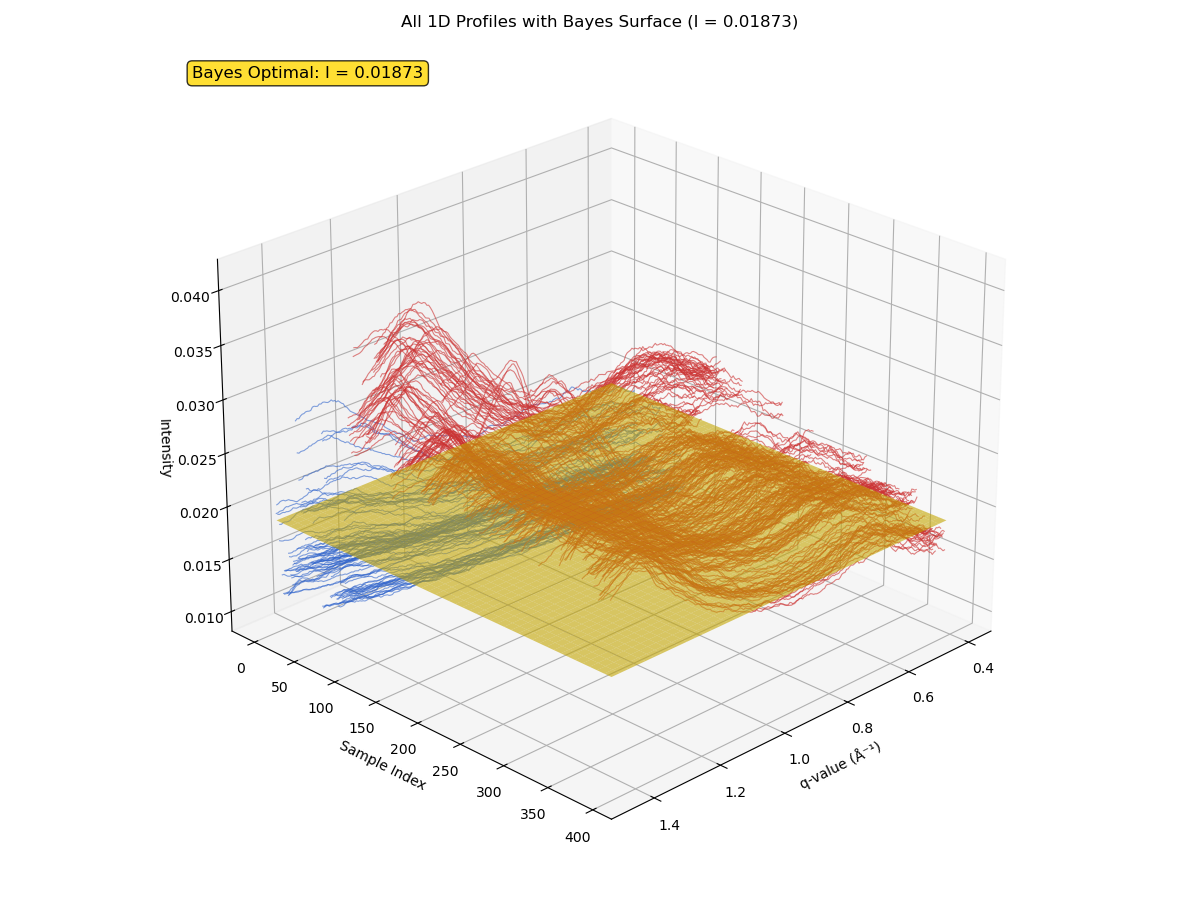

✓ Plot saved: method1_all_data_bayes_surface.png


In [7]:
#!/usr/bin/env python3
"""
Minimal Script: Method 1 - All 1D Data with Bayes Optimal Surface
================================================================

Shows all individual 1D profiles as lines in 3D space with Bayes decision surface.
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_method1_with_bayes(data_dict, feature_metadata=None, bayes_intensity=0.01873):
    """
    Plot all 1D data as lines in 3D cube with Bayes optimal surface.
    
    Args:
        data_dict: {class_label: numpy_array} - e.g., {0: I_mica, 1: I_tissue}
        feature_metadata: Optional q-values array
        bayes_intensity: Bayes optimal threshold intensity
    """
    
    # Prepare data
    X_by_class = {}
    for class_label, arrays in data_dict.items():
        if isinstance(arrays, list):
            # Combine multiple arrays
            min_features = min(arr.shape[1] for arr in arrays)
            aligned = [arr[:, :min_features] for arr in arrays]
            X_by_class[class_label] = np.vstack(aligned)
        else:
            X_by_class[class_label] = arrays
    
    # Align to minimum features
    min_features = min(X.shape[1] for X in X_by_class.values())
    for label in X_by_class:
        X_by_class[label] = X_by_class[label][:, :min_features]
    
    # Set up feature axis
    if feature_metadata is not None:
        feature_axis = feature_metadata[:min_features]
        x_label = 'q-value (Å⁻¹)'
    else:
        feature_axis = np.arange(min_features)
        x_label = 'Feature Index'
    
    # Colors
    class_labels = sorted(X_by_class.keys())
    colors = [(0.2, 0.4, 0.8), (0.8, 0.2, 0.2)]  # Blue, Red
    
    print(f"Plotting {len(class_labels)} classes:")
    for label in class_labels:
        print(f"  Class {label}: {X_by_class[label].shape[0]} samples")
    
    # Create plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all sample lines
    sample_counter = 0
    for class_idx, label in enumerate(class_labels):
        X_class = X_by_class[label]
        color = colors[class_idx]
        
        # Plot each sample as a 3D line
        for i in range(min(300, X_class.shape[0])):
            sample = X_class[i]
            
            # X = q-values, Y = sample index, Z = intensity
            ax.plot(feature_axis, [sample_counter] * len(feature_axis), sample, 
                   color=color, alpha=0.6, linewidth=0.8)
            sample_counter += 1
    
    # Add Bayes optimal surface
    Y_bayes = np.linspace(0, sample_counter, 50)
    Q_bayes, Y_bayes_mesh = np.meshgrid(feature_axis, Y_bayes)
    Z_bayes = np.full_like(Q_bayes, bayes_intensity)
    
    # Plot Bayes surface
    ax.plot_surface(Q_bayes, Y_bayes_mesh, Z_bayes, 
                   color='gold', alpha=0.6, linewidth=0)
    
    # Add contour lines
    ax.contour(Q_bayes, Y_bayes_mesh, Z_bayes, levels=[bayes_intensity], 
              colors='orange', linewidths=2, alpha=0.8)
    
    # Labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Sample Index')
    ax.set_zlabel('Intensity')
    ax.set_title(f'All 1D Profiles with Bayes Surface (I = {bayes_intensity})')
    ax.view_init(elev=25, azim=45)
    
    # Add annotation
    ax.text2D(0.02, 0.95, f"Bayes Optimal: I = {bayes_intensity}", 
              transform=ax.transAxes, fontsize=12, 
              bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('method1_all_data_bayes_surface.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot saved: method1_all_data_bayes_surface.png")

if __name__ == "__main__":
    # Your data loading
    q_values = np.loadtxt("q_mica.txt")

    I_mica = np.loadtxt("I_mica_data.txt")     # (92, 210)
    I_tissue = np.loadtxt("I_tissue_data.txt") # (356, 690)
    
    #d ata dictionary
    data = {0: I_mica, 1: I_tissue}
   
    # Plot with Bayes surface
    plot_method1_with_bayes(data, feature_metadata=q_values, bayes_intensity=0.01873)

Plotting 2 classes:
  Class 0 (Mica): 92 samples, 211 features
  Class 1 (Tissue): 1259 samples, 211 features


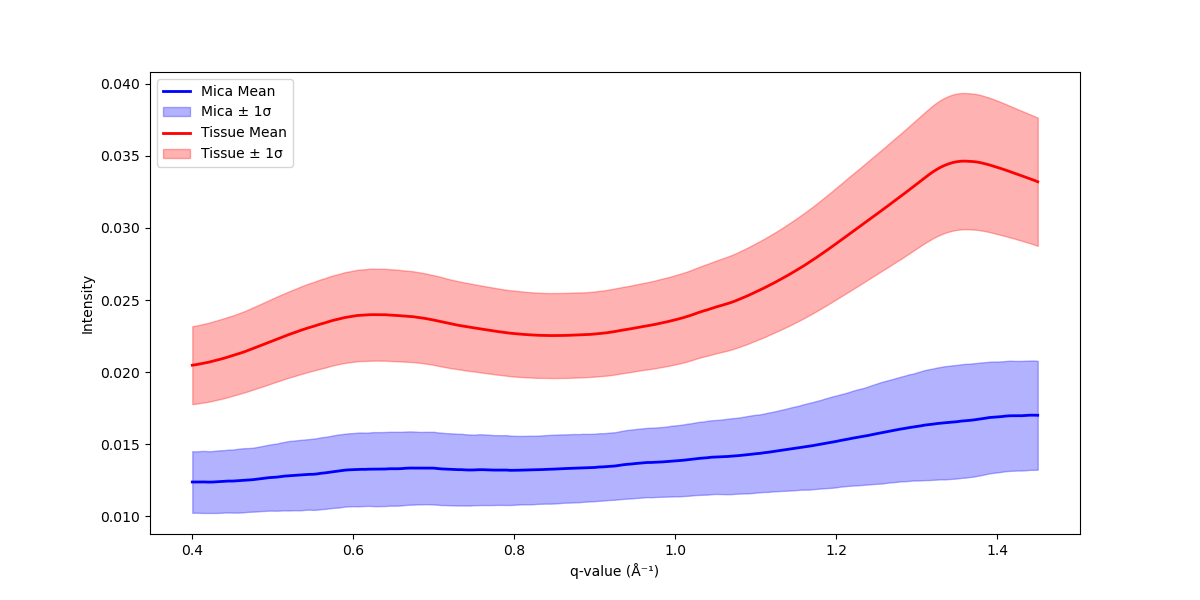

✓ Plot saved: mean_std_comparison.png


In [8]:
#!/usr/bin/env python3
"""
Simple 2D Plot with Mean and Standard Deviation
==============================================

Basic plot showing mean ± std for two classes.
"""

import numpy as np
import matplotlib.pyplot as plt

def plot_mean_std_2d(data_dict, feature_metadata=None):
    """
    Simple 2D plot with mean and standard deviation for two classes.
    
    Args:
        data_dict: {class_label: numpy_array} - e.g., {0: I_mica, 1: I_tissue}
        feature_metadata: Optional q-values array
    """
    
    # Prepare data
    X_by_class = {}
    for class_label, arrays in data_dict.items():
        if isinstance(arrays, list):
            # Combine multiple arrays
            min_features = min(arr.shape[1] for arr in arrays)
            aligned = [arr[:, :min_features] for arr in arrays]
            X_by_class[class_label] = np.vstack(aligned)
        else:
            X_by_class[class_label] = arrays
    
    # Align to minimum features
    min_features = min(X.shape[1] for X in X_by_class.values())
    for label in X_by_class:
        X_by_class[label] = X_by_class[label][:, :min_features]
    
    # Set up feature axis
    if feature_metadata is not None:
        feature_axis = feature_metadata[:min_features]
        x_label = 'q-value (Å⁻¹)'
    else:
        feature_axis = np.arange(min_features)
        x_label = 'Feature Index'
    
    # Compute statistics
    class_labels = sorted(X_by_class.keys())
    colors = ['blue', 'red']
    class_names = ['Mica', 'Tissue']
    
    print(f"Plotting {len(class_labels)} classes:")
    for i, label in enumerate(class_labels):
        print(f"  Class {label} ({class_names[i]}): {X_by_class[label].shape[0]} samples, {X_by_class[label].shape[1]} features")
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    for i, label in enumerate(class_labels):
        X_class = X_by_class[label]
        
        # Compute mean and std
        mean = X_class.mean(axis=0)
        std = X_class.std(axis=0)
        
        # Plot mean line
        plt.plot(feature_axis, mean, '-', color=colors[i], linewidth=2, 
                label=f'{class_names[i]} Mean')
        
        # Plot std band
        plt.fill_between(feature_axis, mean - std, mean + std, 
                        color=colors[i], alpha=0.3, 
                        label=f'{class_names[i]} ± 1σ')
    
    plt.xlabel(x_label)
    plt.ylabel('Intensity')
    # plt.title('Mean ± Standard Deviation Comparison')
    plt.legend()
    plt.grid(False) # , alpha=0.3
    # plt.tight_layout()
    
    # Save and show
    plt.savefig('mean_std_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Plot saved: mean_std_comparison.png")

if __name__ == "__main__":
    # Your data loading
    I_mica = np.loadtxt("I_mica_data.txt")     # (94, 210)
    I_tissue = np.loadtxt("I_tissue_data.txt") # (356, 690)
    q_values = np.loadtxt("q_mica.txt")
    
    # Data dictionary
    data = {0: I_mica, 1: I_tissue}
    
    # Generate simple 2D plot
    plot_mean_std_2d(data, feature_metadata=q_values)

Plotting 2 classes:
  Class 0 (Non-cross-$\beta$): 356 samples, 211 features
  Class 1 (cross-$\beta$): 903 samples, 211 features


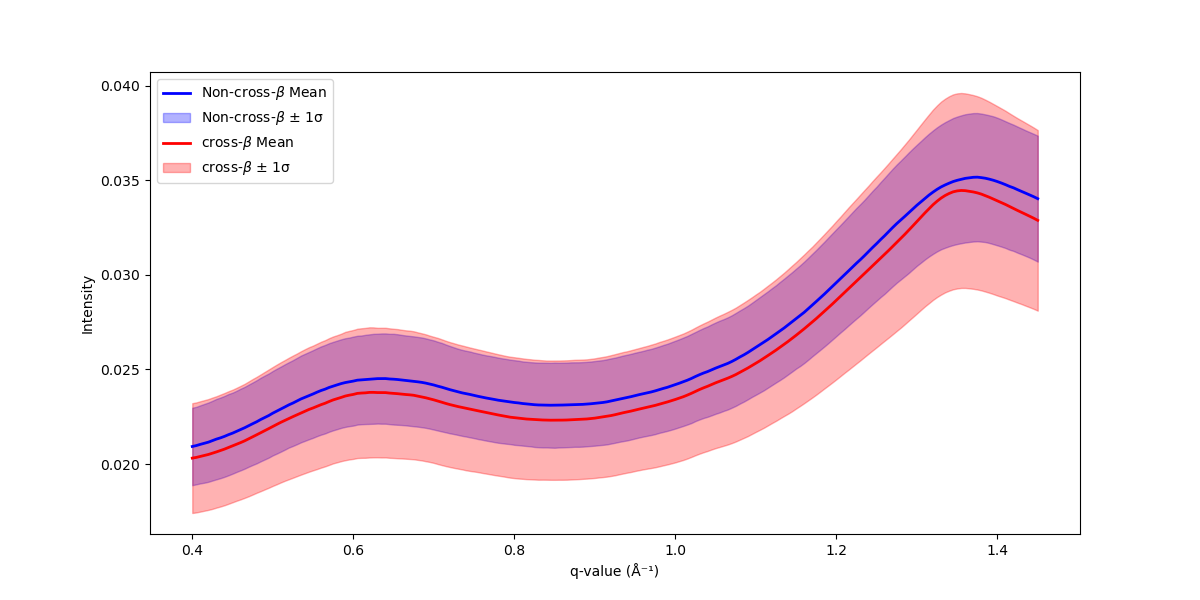

✓ Plot saved: mean_std_comparison.png


In [9]:
#!/usr/bin/env python3
"""
Simple 2D Plot with Mean and Standard Deviation
==============================================

Basic plot showing mean ± std for two classes.
"""

import numpy as np
import matplotlib.pyplot as plt

def plot_mean_std_2d(data_dict, feature_metadata=None):
    """
    Simple 2D plot with mean and standard deviation for two classes.
    
    Args:
        data_dict: {class_label: numpy_array} - e.g., {0: I_mica, 1: I_tissue}
        feature_metadata: Optional q-values array
    """
    
    # Prepare data
    X_by_class = {}
    for class_label, arrays in data_dict.items():
        if isinstance(arrays, list):
            # Combine multiple arrays
            min_features = min(arr.shape[1] for arr in arrays)
            aligned = [arr[:, :min_features] for arr in arrays]
            X_by_class[class_label] = np.vstack(aligned)
        else:
            X_by_class[class_label] = arrays
    
    # Align to minimum features
    min_features = min(X.shape[1] for X in X_by_class.values())
    for label in X_by_class:
        X_by_class[label] = X_by_class[label][:, :min_features]
    
    # Set up feature axis
    if feature_metadata is not None:
        feature_axis = feature_metadata[:min_features]
        x_label = 'q-value (Å⁻¹)'
    else:
        feature_axis = np.arange(min_features)
        x_label = 'Feature Index'
    
    # Compute statistics
    class_labels = sorted(X_by_class.keys())
    colors = ['blue', 'red']
    class_names = [r'Non-cross-$\beta$', r'cross-$\beta$']
    
    print(f"Plotting {len(class_labels)} classes:")
    for i, label in enumerate(class_labels):
        print(f"  Class {label} ({class_names[i]}): {X_by_class[label].shape[0]} samples, {X_by_class[label].shape[1]} features")
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    for i, label in enumerate(class_labels):
        X_class = X_by_class[label]
        
        # Compute mean and std
        mean = X_class.mean(axis=0)
        std = X_class.std(axis=0)
        
        # Plot mean line
        plt.plot(feature_axis, mean, '-', color=colors[i], linewidth=2, 
                label=f'{class_names[i]} Mean')
        
        # Plot std band
        plt.fill_between(feature_axis, mean - std, mean + std, 
                        color=colors[i], alpha=0.3, 
                        label=f'{class_names[i]} ± 1σ')
    
    plt.xlabel(x_label)
    plt.ylabel('Intensity')
    # plt.title('Mean ± Standard Deviation Comparison')
    plt.legend()
    plt.grid(False)  # , alpha=0.3
    # plt.tight_layout()
    
    # Save and show
    plt.savefig('mean_std_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Plot saved: mean_std_comparison.png")

if __name__ == "__main__":
    # Your data loading
    I_mica = np.loadtxt("../data/I_tissue_div_data.txt")    # (94, 210)
    I_tissue = np.loadtxt("../data/I_cross_data.txt") # (356, 690)
    q_values = np.loadtxt("../data/q_data.txt")
    
    # Data dictionary
    data = {0: I_mica[:,lidx:uidx+1], 1: I_tissue[:,lidx:uidx+1]}
    
    # Generate simple 2D plot
    plot_mean_std_2d(data, feature_metadata=q_values[lidx:uidx+1])

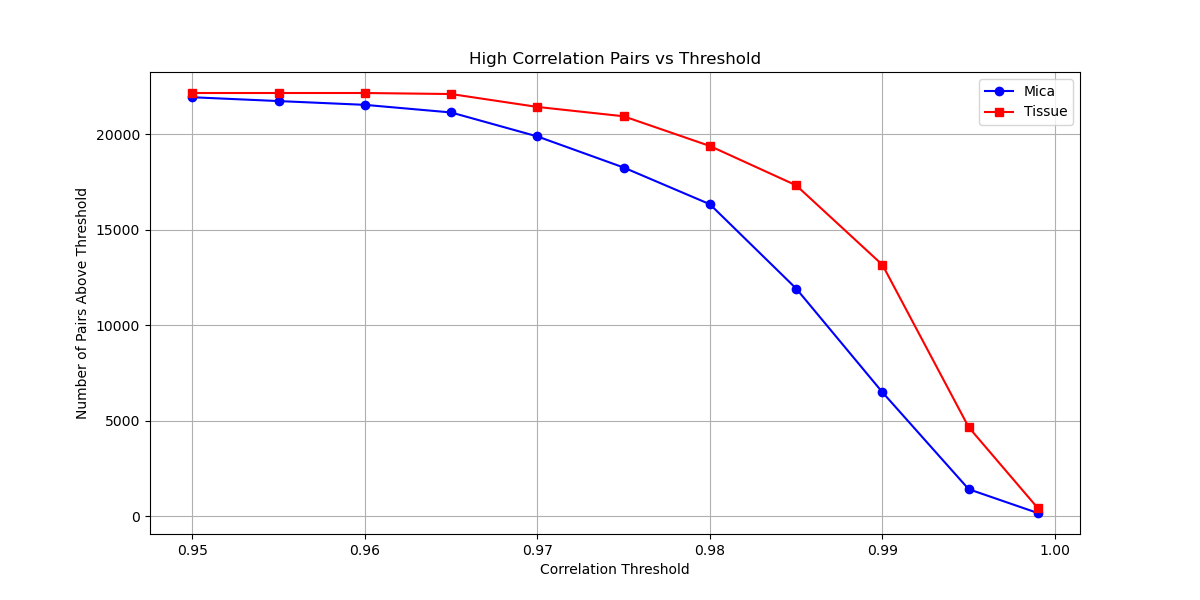

In [10]:
# Plot how feature retention changes across thresholds
thresholds = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 0.999]
mica_pairs = [21933, 21733, 21535, 21137, 19883, 18257, 16335, 11925, 6497, 1427, 182]
tissue_pairs = [22155, 22155, 22155, 22101, 21426, 20937, 19382, 17324, 13164, 4669, 443]

plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.plot(thresholds, mica_pairs, 'o-', color='blue', label='Mica')
plt.plot(thresholds, tissue_pairs, 's-', color='red', label='Tissue')
plt.xlabel('Correlation Threshold')
plt.ylabel('Number of Pairs Above Threshold')
plt.title('High Correlation Pairs vs Threshold')
plt.legend()
plt.grid(True)

In [11]:
# -------- Theorem Validation Helper functions --------
import os, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

SEED = 43
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True # Deterministic flags (CUDA/cuDNN)
torch.backends.cudnn.benchmark     = False # Deterministic flags (CUDA/cuDNN)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng(SEED)


# ------------------------------------------------
# Helpers
# ------------------------------------------------

def load_txt(path):
    try:
        X = np.loadtxt(path)
    except Exception:
        X = np.genfromtxt(path, delimiter=',')
    if X.ndim == 1:
        X = X.reshape(1, -1)
    if np.isnan(X).any():
        raise ValueError(f"NaNs in {path}")
    return X

def cov_matrix(X):
    Xc = X - X.mean(0, keepdims=True)
    n = X.shape[0]
    return (Xc.T @ Xc) / max(n-1, 1)

def block_split(X, Q_keep, Q_prune):
    Q_keep = np.asarray(Q_keep, dtype=int)
    Q_prune = np.asarray(Q_prune, dtype=int)
    if np.intersect1d(Q_keep, Q_prune).size:
        raise ValueError("Q_keep and Q_prune must be disjoint.")
    return X[:, Q_keep], X[:, Q_prune]

def eig_report(S, name="Σ"):
    # Ensure symmetry
    Ssym = 0.5*(S + S.T)
    # Eigenvalues (Hermitian)
    w = np.linalg.eigvalsh(Ssym)
    w_sorted = np.sort(w)
    lam_min, lam_med, lam_max = w_sorted[0], np.median(w_sorted), w_sorted[-1]
    trace  = w.sum()
    cond   = (lam_max / lam_min) if lam_min > 0 else np.inf
    print(f"{name}: shape={S.shape} | λ_min={lam_min:.3e}, λ_med={lam_med:.3e}, λ_max={lam_max:.3e}, "
          f"trace={trace:.3e}, cond={cond:.3e}")
    return w_sorted


def sample_conditional_U(U_mean, Sigma, n_samples):
    """
    For each row U_mean[i] in (n, q), draw n_samples iid vectors from
    N(U_mean[i], Sigma). Returns (n, n_samples, q).

    Parameters
    ----------
    U_mean : np.ndarray, shape (n, q)
        Per-sample mean vectors (e.g., U0 = Z @ A^T + 1 b^T).
    Sigma  : np.ndarray, shape (q, q)
        Shared covariance (symmetric PSD).
    n_samples : int
        Number of Monte Carlo draws per sample.
    Returns
    -------
    U_draws : np.ndarray, shape (n, n_samples, q)
        For each i, U_draws[i, m, :] ~ N(U_mean[i, :], Sigma), iid over m.
    """
    n, q = U_mean.shape
    # Zero-mean noise with covariance Sigma, arranged as (n, n_samples, q)
    noise = rng.multivariate_normal(mean=np.zeros(q), cov=Sigma, size=(n, n_samples))
    # Broadcast per-sample means to (n, 1, q) and add
    MU = U_mean[:, None, :]                  # (n, 1, q)
    return MU + noise                        # (n, n_samples, q)

# ------------------------------------------------
# Define f_theta - Model loading
# ------------------------------------------------

def safe_int(x, default):
    try:
        return int(x)
    except Exception:
        return int(default)

def safe_float(x, default):
    try:
        return float(x)
    except Exception:
        return float(default)

class CustomNN(nn.Module):
    """Ultra-lightweight neural network architecture."""
    def __init__(self, input_dim: int, dropout: float = 0.0, n_classes: int = 2):
        super().__init__()
        input_dim = safe_int(input_dim, 10)
        dropout   = safe_float(dropout, 0.3)
        n_classes = safe_int(n_classes, 2)
        self.feat_dim = 4

        in_channels       = 1
        conv_out_channels = 4
        kernel_size = 3
        padding     = 0
        dilation    = 1
        stride      = 1

        self.conv1 = nn.Conv1d(in_channels, conv_out_channels,
                               kernel_size=kernel_size,
                               padding=padding, dilation=dilation,
                               stride=stride, bias=True)

        conv_length     = (input_dim + 2*padding - dilation*(kernel_size-1) - 1)//stride + 1
        conv_output_dim = conv_out_channels * conv_length

        self.act_conv = nn.LeakyReLU(0.01)
        self.layer1   = nn.Linear(conv_output_dim, 4)
        self.act1     = nn.LeakyReLU(0.01)
        self.dropout  = nn.Dropout(dropout)
        self.classifier = nn.Linear(4, n_classes)

    def forward(self, x):
        # Accept (n, d) or (n, 1, d)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)               # (n, 1, d)
        x = self.conv1(x)                    # (n, 4, d-2) since k=3, stride=1, pad=0
        x = self.act_conv(x)
        x = x.view(x.size(0), -1)            # flatten to (n, 4*(d-2))
        x = self.layer1(x)                   # (n, 4)
        x = self.act1(x)
        x = self.dropout(x)                  # disabled in eval()
        return self.classifier(x)            # logits: (n, n_classes)


# option-1 : Su_hat
def make_psd(S):
    S = 0.5*(S + S.T)
    w, V = np.linalg.eigh(S)
    w = np.clip(w, 1e-12, None)
    return V @ np.diag(w) @ V.T

# ------------------------------------------------
# Per-class estimator with class-specific indices
# ------------------------------------------------
def fit_linear_conditional_U_on_Z(Z, U):
    """
    Fit a multi-output linear model for the pruned block U given kept block Z,
    with an intercept, on a single class (i.e., class-conditional fit).

    Model:
        U ≈ Z A^T + 1 b^T
    where:
        - Z: (n, p) design matrix (with kept indices)
        - U: (n, q) responses (with pruned indices)
        - A: (q, p) slope matrix (one row per U-dimension)
        - b: (q,)   intercept vector (one entry per U-dimension)

    Estimation:
        - Uses ordinary least squares (OLS) via np.linalg.lstsq on [Z, 1].
        - Adds an explicit intercept column to Z (so residual columns have mean ≈ 0).
        - Residual covariance is computed as (ΔU^T ΔU) / (n - 1).

    Returns:
        Ahat : (q, p)   estimated slopes
        bhat : (q,)     estimated intercepts
        Sigma_res : (q, q) residual covariance matrix
        Anchor : (n, q) U0
        Residuals : (n, q) ΔU := U - E[U|Z]
    """
    # Z: (n, p), U: (n, q)
    n, p  = Z.shape
    q     = U.shape[1]

    # Add intercept
    Z1 = np.hstack([Z, np.ones((n, 1))])           # (n, p+1)

    # Least squares fit for multi-output U
    coef, residuals, rank, s = np.linalg.lstsq(Z1, U, rcond=None)  # (p+1, q)

    # Parse slopes/intercept in your convention:
    Ahat = coef[:-1, :].T      # (q, p)
    bhat = coef[-1, :].T       # (q,)

    # Fitted values and residuals
    U0      = Z @ Ahat.T + np.ones((n,1)) @ bhat[None, :]    # (n, q)
    DeltaU  = U - U0                                         # (n, q)
    Sigma_y = (DeltaU.T @ DeltaU) / (n - 1)                  # (q, q)

    # sanity checks
    assert Z1.shape == (n, p+1)
    assert coef.shape == (p+1, q)
    assert Ahat.shape == (q, p) and bhat.shape == (q,)
    assert U0.shape == (n, q) and DeltaU.shape == (n, q)

    return Ahat, bhat, Sigma_y, U0, DeltaU

# -------- Assembly & gradients wrt U (pruned coordinates) helpers --------
def assemble_full_input(Z_t, U_t, d, Q_keep, Q_prune, device):
    n = Z_t.shape[0]
    X_full = torch.zeros((n, d), dtype=torch.float64, device=device)
    X_full[:, Q_keep]  = Z_t
    X_full[:, Q_prune] = U_t
    return X_full

def grad_U_logits_at(f_model, Z_t, U_t, d, Q_keep, Q_prune):
    """
    Return G of shape (n, C, q): G[i, c, :] = ∇_U f^{(c)}(Z_i, U_i).
    """
    X_full = assemble_full_input(Z_t, U_t, d, Q_keep, Q_prune, Z_t.device)
    X_full.requires_grad_(True)
    logits = f_model(X_full)                # (n, C)
    n, C = logits.shape
    q = len(Q_prune)
    G = torch.zeros((n, C, q), dtype=torch.float64, device=Z_t.device)
    for c in range(C):
        grads = torch.autograd.grad(
            outputs=logits[:, c].sum(),
            inputs=X_full,
            create_graph=False, retain_graph=True
        )[0]  # (n, d)
        # retain_graph=True --> reuse the same logits graph each time. Without retaining, the first call would free the graph; the second call would error: “Trying to backward through the graph a second time…”
        # create_graph=False --> PyTorch would record all ops used to compute grads, making grads require grad too (enabling Hessians / second-order stuff).
        
        ## option-2 
        # grads = torch.autograd.grad(
        #     outputs=logits[:, c],
        #     inputs=X_full,
        #     grad_outputs=torch.ones_like(logits[:, c]),
        #     create_graph=False, retain_graph=True
        # )[0]
        
        G[:, c, :] = grads[:, Q_prune]  # (n, C, q)
    return G  # 

def estimate_LHS_RHS_for_class(f_theta, Xy, Q_keep, d, device, nU=256, grid_t=(0.25, 0.5, 0.75, 1), alpha=0.25):
    """
    For class matrix Xy and kept-index set Q_keep:
      - Fit U|Z
      - Compute G at anchor, L_y, LHS (MC)
      - Compute remainder B_y, max|R|
    Returns dict.
    """
    # Step — Split kept/pruned features and diagnostics:
    # Build class-wise blocks Z_y (kept) and U_y (pruned) from Q_keep/Q_prune, record dims (n,p,q),
    Q_keep  = np.asarray(Q_keep, dtype=int)
    Q_prune = np.setdiff1d(np.arange(d), Q_keep, assume_unique=True)
    Zy, Uy  = Xy[:, Q_keep], Xy[:, Q_prune]
    n, p, q = Zy.shape[0], Zy.shape[1], Uy.shape[1]

    # run covariance eig diagnostics on Cov(Zy) and Cov(Uy).
    eig_report(cov_matrix(Zy), name="Cov(Zy)")
    eig_report(cov_matrix(Uy), name="Cov(Uy)")

    # Fit U|Z and stabilize Σ_res
    A_hat, b_hat, Su_hat, U0, DeltaU = fit_linear_conditional_U_on_Z(Zy, Uy)  # (q,p), (q,), (q,q), (n, q), (n, q)
    
    # option-1
    # Su_hat = make_psd(Su_hat)

    # option-2
    Su_hat = 0.5 * (Su_hat + Su_hat.T)                          # symmetrize

    # option-3: jitter
    eps = 1e-4
    Su_hat = Su_hat + eps * np.eye(Su_hat.shape[0])

    # report on Su_hat
    w, V = np.linalg.eigh(Su_hat)
    print("eig(Σ_res) min/max:", w.min(), w.max())
    eig_report(Su_hat, name="Cov(U | Z)  (residual)")      # U | Z
    
    _, _, Sz_res, _, _ = fit_linear_conditional_U_on_Z(Uy, Zy,)  # Z | U
    eig_report(Sz_res, name="Cov(Z | U)  (residual)")

    # gradients at anchor U0
    Zy_t  = torch.from_numpy(Zy).to(device)
    Uy_t  = torch.from_numpy(Uy).to(device)
    U_anchor_t = torch.from_numpy(U0).to(device)
    G_anchor_t = grad_U_logits_at(f_theta, Zy_t, U_anchor_t, d, Q_keep, Q_prune)     # (n, C, q)

    # Signal term Ly = E[ sum_c g_c^T Σ g_c ]
    Su_t = torch.from_numpy(Su_hat).to(device)
    Ly   = torch.einsum('ncq,qQ,ncQ->n', G_anchor_t, Su_t, G_anchor_t).mean().item()

    def check_einsum(Ly, Su_t, G_anchor_t):
        # Recompute L_y via explicit matmul (avoids einsum indexing gotchas)
        GS   = torch.matmul(G_anchor_t, Su_t)                               # (n, C, q) @ (q, q) -> (n, C, q)
        Ly_per_sample = (GS * G_anchor_t).sum(dim=2).sum(dim=1)             # # (n, C, q) -> sum over q -> (n, C) -> (n, C) -> (n,) = sum_c g^T Σ g
        Ly_safe = Ly_per_sample.mean().item()

        print(f"L_y (old einsum) : {Ly:.3e}")
        print(f"L_y (matmul safe): {Ly_safe:.3e}")

    check_einsum(Ly, Su_t, G_anchor_t)

    # LHS: E_Z[ sum_c Var(f^c | Z) ] via MC over U|Z
    U_samps  = sample_conditional_U(U0, Su_hat, n_samples=nU)  # Monte Carlo samples from U|Z: shape (n, nU, q)
    Z_rep    = np.broadcast_to(Zy[:, None, :], (n, nU, p))
    Z_rep_t  = torch.from_numpy(Z_rep.reshape(-1, p)).to(device)
    U_samps_t= torch.from_numpy(U_samps.reshape(-1, q)).to(device)

    with torch.no_grad():
        X_full = assemble_full_input(Z_rep_t, U_samps_t, d, Q_keep, Q_prune, device)
        logits = f_theta(X_full).reshape(n, nU, C)                          # (n, nU, C)
        var_over_U = logits.var(dim=1, unbiased=True)                       # (n, C)
        LHS = var_over_U.sum(dim=1).mean().item()

    # # B_y calculation - Curvature penalty B_y via Hölder exponent - alpha
    DeltaU_t = torch.from_numpy(DeltaU).to(device)          # (n,q)
    eps   = 1e-12
    
    # inputs: G_anchor_t: (n,C,q) = ∇_U f at t=0; Zy_t, U_anchor_t, DeltaU_t; indices; model f_theta
    r      = torch.linalg.norm(DeltaU_t, dim=1)                 # (n,)
    v_hat  = DeltaU_t / (r[:, None] + eps)                      # (n,q)
    mask_i = (r > 0)
    
    ratios_per_t = []   # each entry will be (n, C) numpy
    
    for t in grid_t:
        Ut   = U_anchor_t + t * DeltaU_t                        # (n,q)
        G_t  = grad_U_logits_at(f_theta, Zy_t, Ut, d, Q_keep, Q_prune)  # (n,C,q)
        diff = G_t - G_anchor_t                                 # (n,C,q)
    
        # directional inner product along ΔU direction:
        ip = (diff * v_hat[:, None, :]).sum(dim=2).abs()        # (n,C)
    
        denom  = (t**alpha) * (r**alpha) + eps                  # (n,)
        ratio  = ip / denom[:, None]                            # (n,C)
        ratio  = ratio.masked_fill(~mask_i[:, None], float('nan'))
        ratios_per_t.append(ratio.detach().cpu().numpy())       # (n,C)
    
    # Stack to (n, T, C)
    R_stack = np.stack(ratios_per_t, axis=1)                    # (n, T_eff, C)

    # Robust per-class Hölder constants: 95th percentile over (i,t) for each c
    H_p95_c = np.nanpercentile(R_stack, 95, axis=(0,1))        # (C,)
    H_c     = 1.0 * H_p95_c                                    # mild inflation, (C,)

    moment = float(np.nanmean(r ** (2.0 + 2.0*alpha)))          # scalar
    
    By = float(np.sum((H_c**2) / (alpha + 1.0)**2) * moment)    # scalar
    print(f"By (sum over classes) = {By:.3e}")
    
    
    # RHS
    RHS = (np.sqrt(max(Ly, 0.0)) - np.sqrt(max(By, 0.0)))**2

    margin = LHS - RHS
    return {
        "p": p, "q": q,
        "LHS": float(LHS),
        "Ly": float(Ly),
        "By": float(By),
        "RHS": float(RHS),
        "Q_keep": Q_keep, 
        "Margin":margin,
    }

In [12]:
# ------------------------------------------------
# Validating theorem
# ------------------------------------------------
import pandas as pd
import numpy as np
from essential_func import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

def evaluate_cases(f_theta, X0, X1, Q_indices, d, device, N_U_SAMPLES=1024, T_GRID=None, ALPHA = 0.25):
    """
    Evaluate estimate_LHS_RHS_for_class for BAD and GOOD cases
    
    Parameters:
    -----------
    Q_indices : dict
        Should contain lists:
        - 'Q0_GOOD': list of good index sets for class 0
        - 'Q1_GOOD': list of good index sets for class 1  
        - 'Q0_BAD': single bad index set for class 0
        - 'Q1_BAD': single bad index set for class 1
    """
    results = []

    # Helper to evaluate one case of Q_indices
    def eval_single(case_name, Q0, Q1):
        res0 = estimate_LHS_RHS_for_class(f_theta, X0, Q0, d, device, nU=N_U_SAMPLES, grid_t=T_GRID, alpha=ALPHA)
        res1 = estimate_LHS_RHS_for_class(f_theta, X1, Q1, d, device, nU=N_U_SAMPLES, grid_t=T_GRID, alpha=ALPHA)

        lhs_sup = max(res0['LHS'], res1['LHS'])
        rhs_sup = max(res0['RHS'], res1['RHS'])

        return {
            'Case': case_name,
            'Q0_len': len(Q0),
            'Q1_len': len(Q1),
            # Class 0
            'C0_p': res0['p'], 
            'C0_q': res0['q'],
            'C0_LHS': res0['LHS'],
            'C0_Ly': res0['Ly'],
            'C0_By': res0['By'],
            'C0_RHS': res0['RHS'],
            'C0_Margin': res0['Margin'],
            # Class 1
            'C1_p': res1['p'], 
            'C1_q': res1['q'],
            'C1_LHS': res1['LHS'],
            'C1_Ly': res1['Ly'],
            'C1_By': res1['By'],
            'C1_RHS': res1['RHS'],
            'C1_Margin': res1['Margin'],
            # Overall
            'LHS_sup': lhs_sup, 
            'RHS_sup': rhs_sup,
            'Margin': lhs_sup - rhs_sup
        }

    # Evaluate BAD case
    print("Evaluating BAD case...")
    results.append(eval_single('BAD', Q_indices['Q0_BAD'], Q_indices['Q1_BAD']))
    
    # Evaluate GOOD cases
    n_good = len(Q_indices['Q0_GOOD'])
    print(f"\nEvaluating {n_good} GOOD cases...")
    
    for i in range(n_good):
        print(f"  GOOD_{i+1}/{n_good}")
        results.append(eval_single(f'GOOD_{i+1}', 
                                  Q_indices['Q0_GOOD'][i], 
                                  Q_indices['Q1_GOOD'][i]))
    return pd.DataFrame(results)

# Kept indices as requested
# Q_KEEP_IDX_0_GOOD = [  0,  3,  5,  13,  17,  23,  28,  31,  34,  37,  41,  45,  48,  56,  60,  67,  75,  88,  95,  105,  114,  122,  136,  143,  155,  178,  210]
# Q_KEEP_IDX_1_GOOD = [ 0, 8, 13, 21, 29, 39, 47, 54, 66, 116, 154, 189, 210]

# Q_KEEP_IDX_0_BAD  = [ 0, 13, 23, 37, 48, 210 ]
# Q_KEEP_IDX_1_BAD  = [ 0, 210 ]

# Q_KEEP_IDX_0_GOOD = [ 0, 13, 23, 37, 48, 56, 67, 178, 210 ]
# Q_KEEP_IDX_1_GOOD = [ 0,  8, 21, 47, 154, 189, 210 ]

# Q_KEEP_IDX_0_BAD  = [ 0, 13, 23, 37, 48, 210 ]
# Q_KEEP_IDX_1_BAD  = [ 0, 210 ]

# Example usage -Good[0]-0.991 and Good[1]-0.995 bad is 0.989
if __name__ == "__main__":
    # Example with 5 good index sets per class
    Q_indices = {
        'Q0_GOOD': [
            [ 0, 13, 23, 37, 48, 56, 67, 178, 210 ],
            [ 0, 13, 23, 37, 48, 56, 67, 178, 210 ],
            [ 0,  3,  5,  13,  17,  23,  28,  31,  34,  37,  41,  45,  48,  56,  60,  67,  75,  88,  95,  105,  114,  122,  136,  143,  155,  178,  210]
        ],
        'Q1_GOOD': [
            [ 0, 8,              189, 210 ],
            [ 0, 8, 21, 47, 154, 189, 210 ],
            [ 0, 8, 13, 21, 29, 39, 47, 54, 66, 116, 154, 189, 210]
        ],
        'Q0_BAD': [ 0, 13, 23, 37, 48, 56, 67, 210 ],
        'Q1_BAD': [ 0, 8, 210 ]
    }

    # -------- Load data & model --------
    # qgrid indices
    qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])
    lidx =  qgrid_to_indices(qgrid2, 0.4)
    uidx =  qgrid_to_indices(qgrid2, 1.45)

    # load files
    CLASS0_TXT_PATH = "../data/I_tissue_div_data.txt"         # <-- path to class y=0 data: shape (n0, d) (94, 690)
    CLASS1_TXT_PATH = "../data/I_cross_data.txt"              # <-- path to class y=1 data: shape (n1, d) (356, 690)

    X0 = load_txt(CLASS0_TXT_PATH)[:,lidx:uidx+1]     # (n0, d)
    X1 = load_txt(CLASS1_TXT_PATH)[:,lidx:uidx+1]     # (n1, d)
    assert X0.shape[1] == X1.shape[1], "Class files must have same feature dimension."
    d = X0.shape[1]
    
    C = 2
    print(f'd = {d}')
    f_theta = CustomNN(input_dim=d, dropout=0.0, n_classes=C).double().to(device)
    f_theta.eval()   # IMPORTANT: disable dropout (and any batch-dependent behavior)
    # summary(f_theta, input_size=(11), device="cpu")

    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.vstack([X0, X1]))  # fit on all data (or training split)
    scaler = Normalizer(norm='l2')  # per-row normalization
    scaler = StandardScaler().fit(np.vstack([X0, X1]))
    X0_scaled = scaler.transform(X0)
    X1_scaled = scaler.transform(X1)

    # Run evaluation
    N_U_SAMPLES = 256
    T_GRID      = np.arange(0,1+0.01,0.01)  #  include last
    # ALPHA       = 1
    # df          = evaluate_cases(f_theta, X0_scaled, X1_scaled, Q_indices, d, device, N_U_SAMPLES, T_GRID, ALPHA)
    # print(df)


    ALPHA_VALUES = [0.25, 0.5, 0.75, 1]
    
    # Dictionary to store all dataframes
    dfs = {}
    dir = 'theory_val'
    os.makedirs(dir, exist_ok=True)
    
    # Loop through each alpha value
    for alpha in ALPHA_VALUES:
        print(f"\nEvaluating for alpha = {alpha}...")
        df = evaluate_cases(f_theta, X0_scaled, X1_scaled, Q_indices, d, device, 
                            N_U_SAMPLES, T_GRID, alpha)
        # Store in dictionary
        dfs[alpha] = df
        
        # Save individual CSV files in theory_val directory
        df.to_csv(f'{dir}/results_alpha_{alpha}.csv', index=False)
        print(f"Saved {dir}/results_alpha_{alpha}.csv")
    
    # Combine all results into one dataframe with alpha column
    df_combined = pd.concat([df.assign(alpha=alpha) for alpha, df in dfs.items()], 
                            ignore_index=True)
    
    # Save combined results
    df_combined.to_csv(f'{dir}/results_all_alphas.csv', index=False)
    print("\nSaved combined results to {dir}/results_all_alphas.csv")
    
    # Display summary
    print("\n" + "="*50)
    print("Summary:")
    for alpha in ALPHA_VALUES:
        print(f"Alpha {alpha}: {len(dfs[alpha])} rows")
    print(f"Combined: {len(df_combined)} rows")

d = 211

Evaluating for alpha = 0.25...
Evaluating BAD case...
Cov(Zy): shape=(8, 8) | λ_min=5.720e-03, λ_med=9.865e-03, λ_max=4.459e+00, trace=4.561e+00, cond=7.794e+02
Cov(Uy): shape=(203, 203) | λ_min=6.987e-07, λ_med=3.345e-04, λ_max=1.112e+02, trace=1.130e+02, cond=1.591e+08
eig(Σ_res) min/max: 0.0001006049710123647 0.19580500476121682
Cov(U | Z)  (residual): shape=(203, 203) | λ_min=1.006e-04, λ_med=4.067e-04, λ_max=1.958e-01, trace=9.593e-01, cond=1.946e+03
Cov(Z | U)  (residual): shape=(8, 8) | λ_min=1.258e-05, λ_med=9.687e-05, λ_max=7.200e-04, trace=1.533e-03, cond=5.724e+01
L_y (old einsum) : 3.944e-04
L_y (matmul safe): 3.944e-04
By (sum over classes) = 4.569e-05
Cov(Zy): shape=(3, 3) | λ_min=1.369e-02, λ_med=5.054e-02, λ_max=3.391e+00, trace=3.455e+00, cond=2.477e+02
Cov(Uy): shape=(208, 208) | λ_min=1.163e-06, λ_med=3.624e-04, λ_max=2.390e+02, trace=2.414e+02, cond=2.054e+08
eig(Σ_res) min/max: 0.00010110834982868671 0.7486397693215732
Cov(U | Z)  (residual): shape=(208, 2